# V1 Analysis

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
import matplotlib as mpl
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 0.5
%matplotlib inline

from scipy.io import loadmat
from tqdm import tqdm

from collections import namedtuple

import datajoint as dj
import numpy as np
import pandas as pd
from v1_likelihood import train
from v1_likelihood.analysis import LikelihoodStats
from v1_likelihood.utils import bin_loc, binned_group, binned_stats
from itertools import count, product
from collections import OrderedDict
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.stats import ttest_rel, wilcoxon, ttest_1samp
from scipy.stats import norm
from matplotlib import patches

In [4]:
from collections import namedtuple

Aggregate = namedtuple('Aggregate', ['resp_a', 'model_correct', 'logl', 'presp_a'])
def aggr_model_perf(key, lc_id=32, decoder_id=3, lc_shuffle_id=0):
    restr = dict(lc_id=lc_id, decoder_id=decoder_id, lc_shuffle_id=lc_shuffle_id)
    data = (cd_dlset.CVSet.Member * cd_dlset.LCModelFits & key & restr).fetch()
    aggr = {}
    ordering = np.concatenate(data['test_indices'], axis=1)
    pos = np.argsort(ordering.squeeze())
    model_choice = np.concatenate(data['model_choice'])[pos].squeeze()
    model_correct = np.concatenate(data['model_correct'])[pos].squeeze()
    logl = np.concatenate(data['lc_test_logl'])[pos].squeeze()
    presp_a = np.exp(logl)
    presp_a[model_choice != model_correct] = 1 - presp_a[model_choice != model_correct]
    return Aggregate(model_choice, model_correct, logl, presp_a)
    

In [5]:
cd_dataset = dj.create_virtual_module('cd_dataset', 'edgar_cd_dataset')
class_discrimination = dj.create_virtual_module('class_discrimination', 'edgar_class_discrimination')
cd_lc = dj.create_virtual_module('cd_lc', 'edgar_cd_lc')
cd_dlset = dj.create_virtual_module('cd_dlset', 'edgar_cd_dlset');
ephys = dj.create_virtual_module('ephys', 'ephys')
stimulation = dj.create_virtual_module('stimulation', 'stimulation')

In [6]:
def add_subplots(*args, fig=None):
    if fig is None:
        fig = plt.gcf()
    return [fig.add_subplot(gs) for gs in args]

In [7]:
def get_summary(restr=None, subject=None, model=32, decoder=3, shuffle=0):
    if restr is None:
        restr = {}
    if subject is not None:
        subj = 'subject_id = {}'.format(subject)
    else:
        subj = {}
    target = (cd_dlset.CVSet * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup * class_discrimination.CleanSpikeCountSet & restr & subj)
    cvset = target.fetch('KEY', order_by=','.join(target.primary_key))

    #     model = 32
    #     decoder = 3
    #     shuffle = 0

    cond = dict(lc_id=model, decoder_id=decoder, lc_shuffle_id=shuffle)
    contrasts = np.array([float(c['dataset_contrast']) for c in cvset])

    list_model_resp_A = []
    list_monkey_resp_A = []
    list_test_logl = []
    list_correct_resp = []
    list_cont_vals = []
    list_n_trials = []
    
    for i, c in enumerate(cvset):
        data = (cd_dlset.LCModelFits & c & cond).fetch(order_by='cv_n')
        test_logl = np.concatenate(data['lc_test_logl'])
        n_trials = len(test_logl)
        list_cont_vals.append([float(c['dataset_contrast'])] * n_trials)
        list_n_trials.append(n_trials)
        list_test_logl.append(test_logl)
        model_resp = np.exp(test_logl)
        model_resp_A = np.concatenate(data['model_choice'])
        correct_resp = np.concatenate(data['model_correct'])
        list_correct_resp.append(correct_resp)
        monkey_resp_A = (model_resp_A == correct_resp)
        list_monkey_resp_A.append(monkey_resp_A)
        model_resp_A = model_resp.copy()
        model_resp_A[~monkey_resp_A] = 1 - model_resp_A[~monkey_resp_A]
        list_model_resp_A.append(model_resp_A)

    summary = {}
    summary['contrast'] = contrasts
    summary['correct_resp'] = list_correct_resp
    summary['model_resp_A'] = list_model_resp_A
    summary['monkey_resp_A'] = list_monkey_resp_A
    summary['test_logl'] = list_test_logl
    summary['n_trials'] = list_n_trials
    summary['cont_vals'] = list_cont_vals
    
    return summary

## Configure plot RC

In [117]:
# make font exportable
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.0
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2.0
mpl.rcParams['ytick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

mpl.rcParams['xtick.minor.size'] = 2.0
mpl.rcParams['ytick.minor.size'] = 2.0


mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['font.size'] = 6.0
mpl.rcParams['font.sans-serif'] = ['Liberation Sans']

tom_color = np.array([1, 1, 1]) * 0
leo_color = np.array([1, 1, 1]) * 0.5
cp = sns.color_palette("RdBu_r")

c1_color = cp[-1]
c2_color = cp[0]

# Figure 1 - Behavioral information

In [29]:
leo_data = (class_discrimination.ClassDiscriminationTrial & class_discrimination.CleanSpikeCountTrials & 'subject_id = 3').fetch()
tom_data = (class_discrimination.ClassDiscriminationTrial & class_discrimination.CleanSpikeCountTrials & 'subject_id = 21').fetch()
all_data = (class_discrimination.ClassDiscriminationTrial & class_discrimination.CleanSpikeCountTrials).fetch()

[0.005 0.01  0.02  0.03  0.05  0.1   0.9  ]


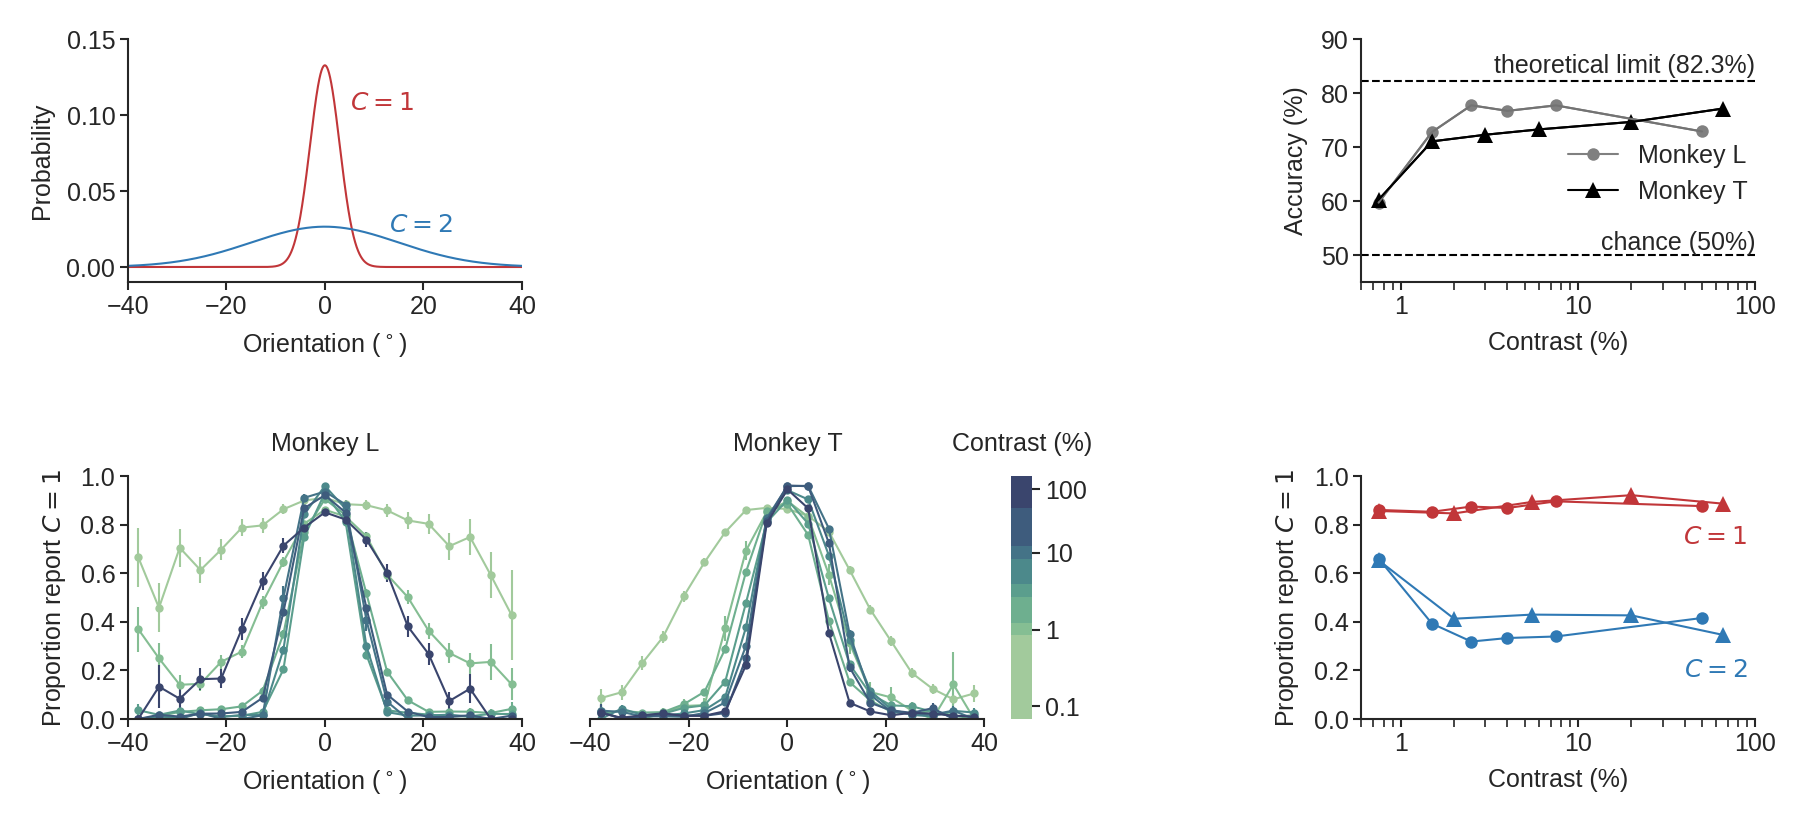

In [30]:
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3


fig = plt.figure(figsize=(7, 3), dpi=300)

gs = gridspec.GridSpec(2, 11, hspace=0.8, wspace=0.8)
#gs_bottom = gridspec.GridSpec(1, 4, top=0.45, hspace=0.8, wspace=0.1)

gs_distr = gs[0, :3]
gs_cond_response = gs[1, -3:]
gs_performance = gs[0, -3:]
gss_psychometric = gs[1, :3], gs[1, 3:6]
gs_colormap = gs[1, 6]


# plot probablity distributions
ax, = add_subplots(gs_distr)
ori = np.linspace(-50, 50, 8000)
sigma_a = 3
sigma_b = 15

pa = np.exp(-ori**2/2/sigma_a**2)/np.sqrt(2 * np.pi * sigma_a**2)
pb = np.exp(-ori**2/2/sigma_b**2)/np.sqrt(2 * np.pi * sigma_b**2)


delta = (ori[-1] - ori[0]) / len(ori)
mixed = 0.5 * (pa + pb)

choice_a = pa > pb
prop_a = pa[choice_a] / (pa[choice_a] + pb[choice_a]) * mixed[choice_a] * delta
choice_b = ~choice_a
prop_b = pb[choice_b] / (pa[choice_b] + pb[choice_b]) * mixed[choice_b] * delta

p_correct = prop_a.sum() + prop_b.sum()

linewidth=0.5
ax.plot(ori, pa, color=c1_color, linewidth=linewidth, label='C=1')
ax.text(5, 0.1, '$C=1$', verticalalignment='bottom', horizontalalignment='left', fontsize=fs, color=c1_color)
ax.plot(ori, pb, color=c2_color, linewidth=linewidth, linestyle='-', label='C=2')
ax.text(13, 0.02, '$C=2$', verticalalignment='bottom', horizontalalignment='left', fontsize=fs, color=c2_color)


ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel(r'Probability', fontsize=fs, labelpad=labelpad)
ax.set_ylim([-0.01, 0.15])
ax.set_xlim([-40, 40])
ax.set_yticks([0,0.05, 0.1, 0.15])
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
#ax.legend(fontsize=fs)


#### Plot conditioned response  ######
ax, = add_subplots(gs_cond_response)
select_a = (tom_data['selected_class'] == 'A').astype(float)
stim_class = (tom_data['stimulus_class'] == 'A')
contrasts = tom_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 6))

ra_conda = select_a[stim_class]
cont_conda = contrasts[stim_class]
ra_condb = select_a[~stim_class]
cont_condb = contrasts[~stim_class]

stats = binned_stats(cont_conda, ra_conda, cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker='^', ms=4, color=c1_color)
stats = binned_stats(cont_condb, ra_condb,  cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker='^', linestyle='-', ms=4, color=c2_color)

select_a = (leo_data['selected_class'] == 'A').astype(float)
stim_class = (leo_data['stimulus_class'] == 'A')
contrasts = leo_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))

ra_conda = select_a[stim_class]
cont_conda = contrasts[stim_class]
ra_condb = select_a[~stim_class]
cont_condb = contrasts[~stim_class]

stats = binned_stats(cont_conda, ra_conda, cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker='o', ms=3, color=c1_color)
ax.text(0.9, 0.8, '$C=1$', verticalalignment='top', horizontalalignment='right', fontsize=fs, color=c1_color)
stats = binned_stats(cont_condb, ra_condb, cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker='o', linestyle='-', ms=3, color=c2_color)
ax.text(0.9, 0.25, '$C=2$', verticalalignment='top', horizontalalignment='right', fontsize=fs, color=c2_color)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([0.45, 1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel(r'Proportion report $C=1$', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)


#### Performance curve ######
ax, = add_subplots(gs_performance)

contrasts = leo_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
print(cont_edges)
correct = leo_data['correct_response'].astype(float) * 100
stats = binned_stats(contrasts, correct, cont_edges)

ax.plot(stats.binc, stats.mu, marker='o', ms=3, label='Monkey L', color=np.r_[leo_color, [1]])
ax.errorbar(stats.binc, stats.mu, stats.sem, color=leo_color*0.9)

contrasts = tom_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
correct = tom_data['correct_response'].astype(float) * 100

stats = binned_stats(contrasts, correct, cont_edges)

ax.plot(stats.binc, stats.mu, marker='^', ms=4, label='Monkey T', color=np.r_[tom_color, [1]])
ax.errorbar(stats.binc, stats.mu, stats.sem, color=tom_color*0.9)

ax.axhline(p_correct * 100, linestyle='--', color='k')
ax.text(1, p_correct *100 + 0.5, 'theoretical limit (82.3%)', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.axhline(50, linestyle='--', color='k')
ax.text(1, 50.05, 'chance (50%)', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([45, 90])
ax.set_yticks([50, 60, 70, 80, 90])
tx=ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Accuracy (%)', fontsize=fs, labelpad=labelpad)
ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
#ax.minorticks_off()



##### Psychometric functions #####
# set color
colors = sns.cubehelix_palette(12, start=0.5, rot=-.75)[2:]
sns.set_palette(colors)
axs = add_subplots(*gss_psychometric)
ori_edges = np.linspace(-40, 40, 20)
cont_edges = np.percentile(all_data['contrast'], np.linspace(0, 100, 9))


for i, ax, data_source, title in zip(count(), axs, [leo_data, tom_data], ['Monkey L', 'Monkey T']):
    contrasts = data_source['contrast'].astype(float)
    correct = data_source['correct_response'].astype(float)
    ori = data_source['orientation'] - 270
    resp_a = (data_source['selected_class'] == 'A').astype(float)
    

    contc = 0.5 * (cont_edges[1:] + cont_edges[:-1])
    
    for g, c in zip(binned_group(contrasts, cont_edges), contc):
        x = ori[g]
        y = resp_a[g]
        stats = binned_stats(x, y, ori_edges)
        ax.errorbar(stats.binc, stats.mu, stats.sem, marker='o', markersize=2, label='{:.1f}'.format(c*100))
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-40, 40])
    ax.set_ylim([0, 1])
    ax.set_xticks([-40, -20, 0, 20, 40])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
    if i==0:
        ax.set_ylabel(r'Proportion report $C=1$', fontsize=fs, labelpad=labelpad)
        sns.despine(offset=offset, ax=ax, trim=trim)
    else:
        #legend = ax.legend(title='Binned\ncontrast (%)', loc='upper left', bbox_to_anchor=[1.05, 1.2], fontsize=fs, )
        #legend.get_title().set_fontsize(fs)
        ax.set_yticks([])
        sns.despine(offset=offset, ax=ax, trim=trim, left=True)
    ax.tick_params(labelsize=fs, pad=pad)

###### Colormap for psychometric function ####
ax, = add_subplots(gs_colormap)
v = np.logspace(np.log10(0.0005), np.log(0.99), 20)[:, None]
cadj = cont_edges.copy()
pos = np.sum(v >= cont_edges, axis=1, keepdims=True)-1
pos[pos<0] = 0
tickloc = np.array([0.001, 0.01, 0.1, 1])
tickpos = np.argmin(np.abs(v - tickloc), axis=0)
sns.heatmap(pos[::-1], cmap=colors[:8], vmin=np.min(pos)-0.5, vmax=7.5, ax=ax, cbar=False)
ax.set_yticks(tickpos[::-1] - 0.5)
ax.set_ylim([19.5, 0.5])
ax.set_yticklabels([0.1, 1, 10, 100], fontsize=fs, rotation=0)
ax.set_xticks([])
ax.set_title('Contrast (%)', fontsize=fs)
ax.yaxis.tick_right()
bounds = list(ax.get_position().bounds)
bounds[0] -= 0.02
bounds[2] = bounds[2]/4
ax.set_position(bounds)
ax.tick_params(labelsize=fs, pad=pad)

fig.savefig('fig01.pdf')
fig.savefig('fig01.eps')
#fig.tight_layout()

# Figure 2: Raw data and processing sequence

In [31]:
header = class_discrimination.CleanSpikeCountSet * class_discrimination.CSCLookup * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash')
keys = (header * cd_dlset.CVSet & 'subject_id = 21').fetch('KEY')
key = keys[214]

contrast = float(key['dataset_contrast'])

trial_data = (class_discrimination.ClassDiscriminationTrial * class_discrimination.SpikeCountTrials & class_discrimination.CleanSpikeCountTrials & key).fetch(order_by='trial_num')
trial_data = trial_data[trial_data['contrast'] == contrast]
likelihood_data = loadmat((cd_dlset.DLSetInfo & 'decoder_id=3 and lc_shuffle_id=1' & key).fetch1('dataset_path'))['dataSet'][0, 0]
l_stats = (LikelihoodStats & key & 'decoder_id=3 and lc_shuffle_id=0').fetch1()
bayes_model_resp = aggr_model_perf(key, lc_id=32, decoder_id=3, lc_shuffle_id=0)
nb_model_resp = aggr_model_perf(key, lc_id=38, decoder_id=3, lc_shuffle_id=0)
print('Contrast={}, {} trials found'.format(contrast, len(trial_data)))

Contrast=0.64, 987 trials found


Using seed 320


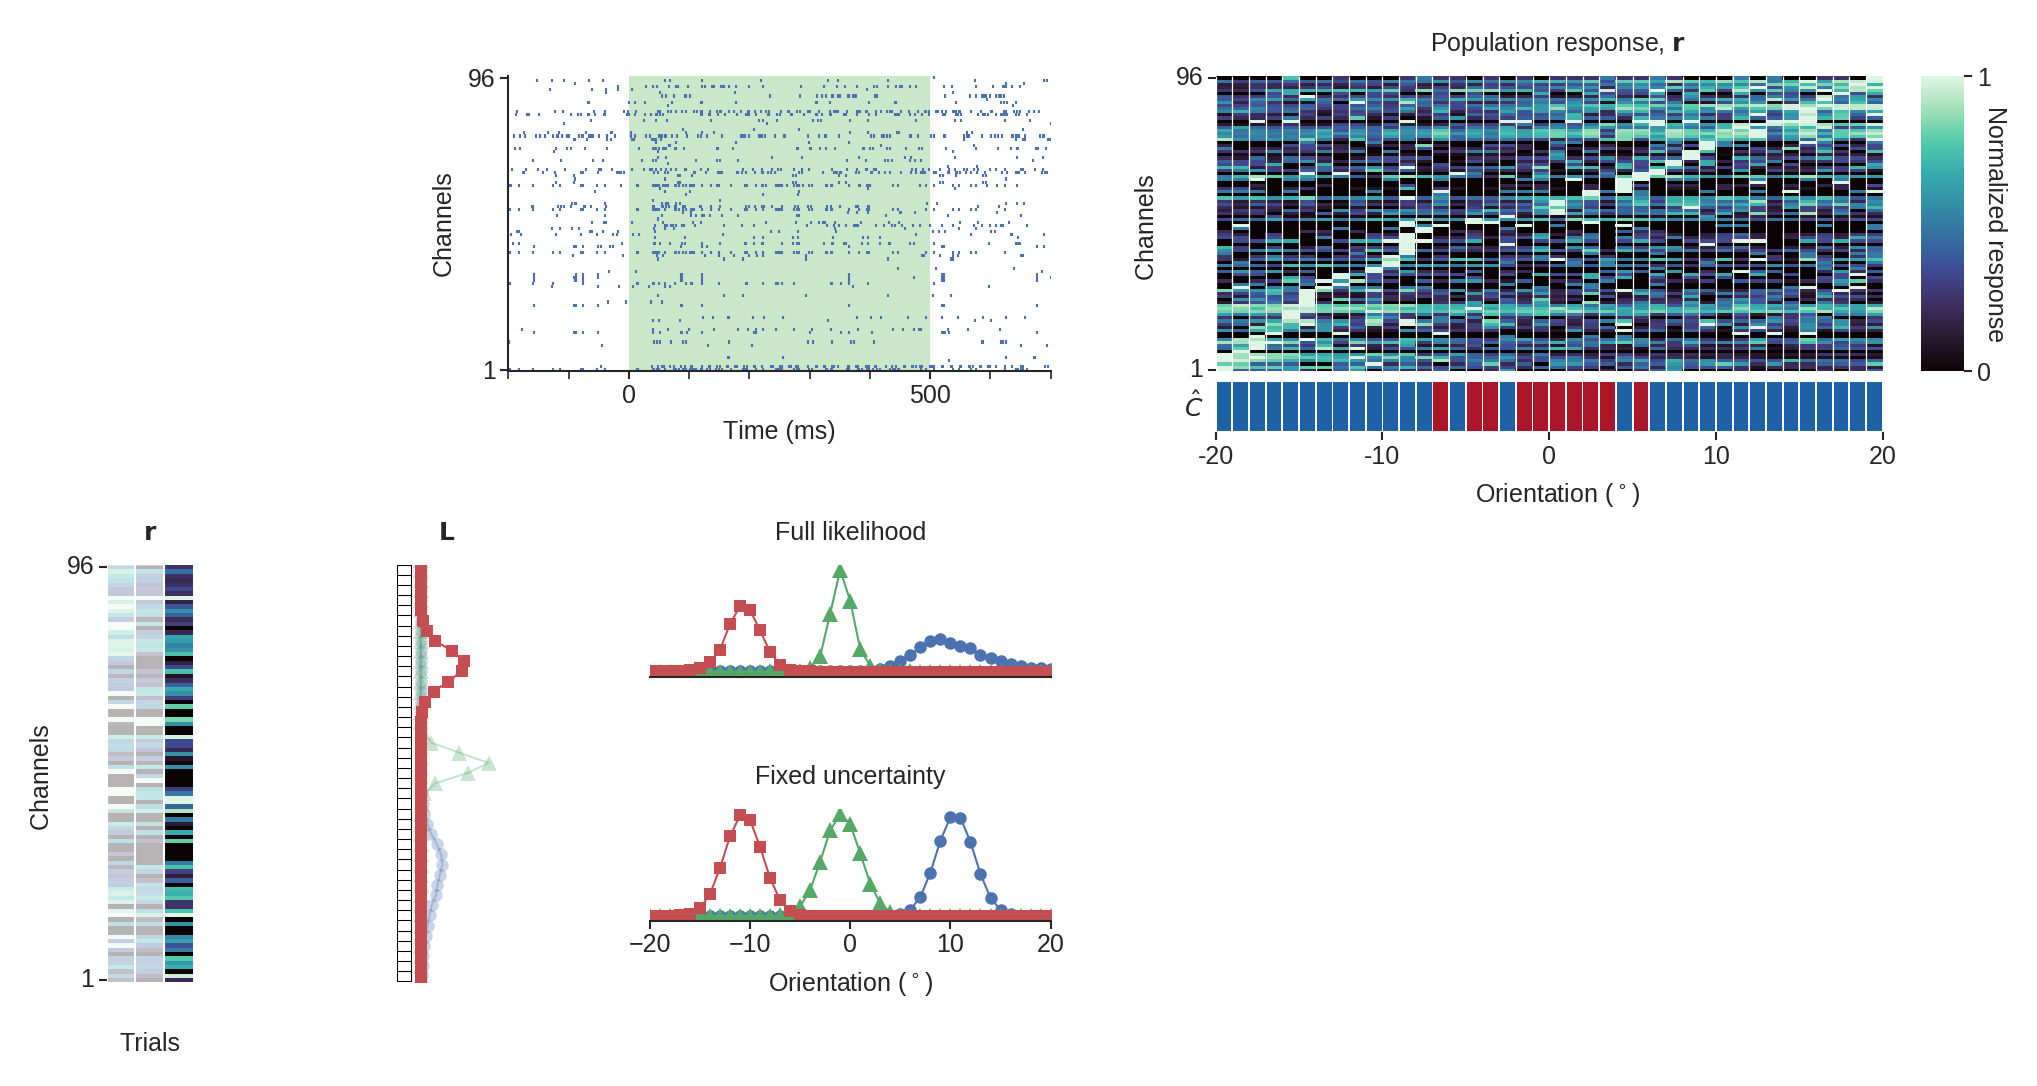

In [122]:
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

fig = plt.figure(figsize=(7.2, 4), dpi=300)


gs = gridspec.GridSpec(15, 12, hspace=hspace, wspace=wspace)
gs_right = gridspec.GridSpec(15, 1, left=0.91, right=0.93, hspace=hspace, wspace=wspace)
gs_left = gridspec.GridSpec(15, 1, left=0.07, right=0.11, hspace=hspace, wspace=wspace)
gs_outputs = gridspec.GridSpec(15, 2, left=0.15, right=0.25, hspace=hspace, wspace=wspace)

#gs_bottom = gridspec.GridSpec(1, 4, top=0.45, hspace=0.8, wspace=0.1)

gs_raster = gs[:5, 2:6]
gs_counts = gs[:5, 7:12]
gs_resp = gs[5, 7:12]
gs_counts_cbar = gs_right[:5, 0]


gs_rs = gs_left[8:, 0]

gs_likelihoods = gs[8:10, 3:6]
gs_non_bayesian = gs[12:14, 3:6]

gs_readout = gs_outputs[8:, 1]
gs_grids = gs_outputs[8:, 0]

#gs_model_resp = gs[8, 6:9]
#gs_class_cbar = gs_right[8, 0]



######### Counts plot ##############
ax, = add_subplots(gs_counts)
cax, = add_subplots(gs_counts_cbar)

counts = np.stack(trial_data['counts']).squeeze()
selection = trial_data['stimulus_class'] == 'A'
ori = trial_data['orientation'] - 270
pos = np.argsort(ori)
sorted_ori = ori[pos]

n_trials = 41
ori_crossing = np.arange(-20, 21)
oriticks = np.array([-20, -10, 0, 10, 20])
crossing_site = []
seed = 320 #np.random.randint(0, 1000)
print('Using seed {}'.format(seed))
np.random.seed(seed)
for v in binned_group(sorted_ori.ravel(), ori_crossing):
    crossing_site.append(np.random.choice(v[0]))
samples = pos[crossing_site]

filt = [0.25, 0.5, 0.25]
norm_counts = counts / (np.max(counts[samples], axis=0, keepdims=True) + 1e-5)
filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=norm_counts[samples])
# ordering for channels
ordering = np.argsort(np.argmax(filtered, axis=0))

sns.heatmap(norm_counts[samples][:, ordering].T, cmap=sns.cm.mako, vmin=0, vmax=1.0, ax=ax, cbar=True, cbar_ax=cax, cbar_kws={'ticks':[0, 1.0]})
#cax = fig.axes[-1] # get colorbar axes that was just added
cax.set_ylabel('Normalized response', rotation=-90, fontsize=fs)
cax.tick_params(labelsize=fs, pad=pad)
ax.vlines(np.arange(n_trials), *ax.get_ylim(), color='w', linewidth=0.3)

ax.set_xlim(0, n_trials)
ax.set_ylim([0, 96])
ax.set_yticks([0.5, 95.5])
ax.set_yticklabels(['1', '96'], rotation=0, ha='right', va='center')
ax.set_xticks([])
ax.set_ylabel('Channels ', fontsize=fs)
ax.set_title(r'Population response, $\mathbf{r}$', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)

######## Response map #######
ax, = add_subplots(gs_resp)
cp = sns.color_palette("RdBu_r", 10)
sns.heatmap(selection[None, samples], square=False, vmax=1, vmin=0, cmap=cp, cbar=False, linewidth=0.2, ax=ax)

ax.set_xlim(0, n_trials)
ax.set_xticks(oriticks+20)
ax.set_xticklabels(oriticks, rotation=0)
ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)

ax.set_yticks([])
ax.set_ylabel(r"$\hat{C}$", fontsize=fs, rotation=0, verticalalignment='center', 
              labelpad=labelpad, horizontalalignment='right')
ax.tick_params(labelsize=fs, pad=pad)

####### Raster plot ##############
sns.set_palette('deep')
ax, = add_subplots(gs_raster)
    
ax.set_xticks([])
ax.set_yticks([])

trial_num = 4
spks = (ephys.SpikesAlignedTrial() &  trial_data[trial_num]).fetch('spikes_aligned', order_by='unit_id')

#spks = spks[ordering]
for i, sp in enumerate(spks):
    ax.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i+1, linewidths=0.5)
    
ax.set_xticks([0, 500])
ax.set_xlabel('Time (ms)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Channels', fontsize=fs, labelpad=labelpad)
ax.set_xlim([-200, 700])
ax.set_ylim([0.5, 96.5])
ax.set_yticks([1, 96])
ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
ax.axvspan(0, 500, facecolor='#2ca02c', edgecolor=None, alpha=0.25)
sns.despine(offset=offset, ax=ax, trim=trim)
ax.tick_params(labelsize=fs, pad=pad)


######## Example counts to be decoded ########
ax, = add_subplots(gs_rs)
trials = [0, 4, 8]
sns.heatmap(norm_counts[trials][:, ordering].T, cmap=sns.cm.mako, vmin=0, vmax=1.0, ax=ax, cbar=False, cbar_kws={'ticks':[0, 1.0]})

# overlay gray map
ax.axvspan(0, 2, alpha=0.7, color=[1, 1, 1])
ax.vlines(np.arange(len(trials)), *ax.get_ylim(), color='w', linewidth=0.5)
ax.set_xlim(0, len(trials))
ax.set_xticks([])
ax.set_yticks([0.5, 95.5])
ax.set_yticklabels(['1', '96'], rotation=0, ha='right', va='center')
ax.set_xlabel('Trials', fontsize=fs, labelpad=4*labelpad)
ax.set_ylabel('Channels ', fontsize=fs, labelpad=labelpad)
ax.set_title(r'$\mathbf{r}$', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)
ax.invert_yaxis()

####### Example decoded likelhoods from the NN #########
ax, = add_subplots(gs_readout)
sample_ori = np.arange(-30, 31).astype(float)
decode_ori = likelihood_data['decodeOri'].ravel() - 270
markers = ['o', '^', 's']
marker_sizes = [3, 4, 3]


for idx, i, mk, ms in zip(count(), trials, markers, marker_sizes):
    L = likelihood_data['oldLikelihood'][:, i]
    f = interp1d(decode_ori, L)
    Ld = f(sample_ori)
    Ld /= Ld.sum()
    alpha = 1 if idx == len(trials)-1 else 0.3
    ax.plot(Ld, sample_ori, '-', marker=mk, ms=ms, linewidth=0.5, alpha=alpha)

patch_offset = 0.05
delta = np.diff(sample_ori).mean()
patch_width = 0.075
for ori in sample_ori:
#     p = patches.Rectangle((-x_scale, ori-delta/2), width=x_scale, height=delta, fill=True, color='b', edgecolor='k', linewidth=0.5)
    p = patches.Rectangle((-patch_width-patch_offset, ori-delta/2), patch_width, delta, fill=False,  edgecolor='k', linewidth=0.25)
    ax.add_patch(p)

ax.add_patch(p)
xlim = ax.get_xlim()
ax.set_xlim([- patch_width - patch_offset, 0.4])
ax.set_yticks([])
ax.set_xticks([])
#ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
ax.set_ylim([-20.5, 20.55])
ax.invert_yaxis()
ax.tick_params(labelsize=fs, pad=pad)
sns.despine(ax=ax, left=True, bottom=True)
ax.set_title(r'$\mathbf{L}$', fontsize=fs)

##### Readout likelihoods for full likelihood model ######
ax, = add_subplots(gs_likelihoods)
sample_ori = np.arange(-30, 31).astype(float)
decode_ori = likelihood_data['decodeOri'].ravel() - 270
markers = ['o', '^', 's']
marker_sizes = [3, 4, 3]

for i, mk, ms in zip(trials, markers, marker_sizes):
    L = likelihood_data['oldLikelihood'][:, i]
    f = interp1d(decode_ori, L)
    Ld = f(sample_ori)
    Ld /= Ld.sum()
    ax.plot(sample_ori, Ld, '-', marker=mk, ms=ms, linewidth=0.5)
    
ax.set_yticks([])
ax.set_xticks([])
#ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
ax.set_xlim([-20, 20])
sns.despine(ax=ax, trim=trim, offset=offset, left=True)
ax.set_title('Full likelihood', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)

##### Readout non-Bayesian approximated likelihoods #####
ax, = add_subplots(gs_non_bayesian)
sample_ori = np.arange(-30, 31).astype(float)
markers = ['o', '^', 's']
marker_sizes = [3, 4, 3]
sigma = l_stats['mean_sigma']
peaks = likelihood_data['originalPeaks'].squeeze() - 270

for i, mk, ms in zip(trials, markers, marker_sizes):
    L = norm.pdf(sample_ori, loc=peaks[i], scale=sigma)
    L /= L.sum()
    ax.plot(sample_ori, L, '-', marker=mk, ms=ms, linewidth=0.5)
    
sns.despine(ax=ax, trim=trim, offset=offset, left=True)
ax.set_yticks([])
ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
#ax.set_ylabel('Likelihood (a.u.)', fontsize=fs, labelpad=labelpad)
ax.set_xlim([-20, 20])
ax.set_title('Fixed uncertainty', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)


# ## Model response map
# ax, = add_subplots(gs_model_resp)
# cax, = add_subplots(gs_class_cbar)
# cp = sns.color_palette("RdBu_r", 10)
# model_prespa = bayes_model_resp.presp_a
# sns.heatmap(model_prespa[None, samples], square=False, vmax=1, vmin=0, cmap=cp, cbar=True, cbar_ax=cax, 
#             cbar_kws={'ticks':[0,0.5, 1.0]}, linewidth=0.2, ax=ax)
# cax.tick_params(labelsize=fs)
# #cax.set_title(r"$P(\hat{C}=1)$", fontsize=fs)
# ax.set_yticks([])
# ax.set_xlim(0, n_trials)
# ax.set_xticks([])
# ax.set_ylabel(r"$P(\hat{C}=1)$", fontsize=fs, rotation=0, verticalalignment='center', horizontalalignment='right')
# ax.tick_params(labelsize=fs)
# ax.set_xticks(oriticks+20)
# ax.set_xticklabels(oriticks, rotation=0)
# ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
# ax.xaxis.tick_top()


fig.savefig('fig02.pdf')
fig.savefig('fig02.eps')

Using seed 320


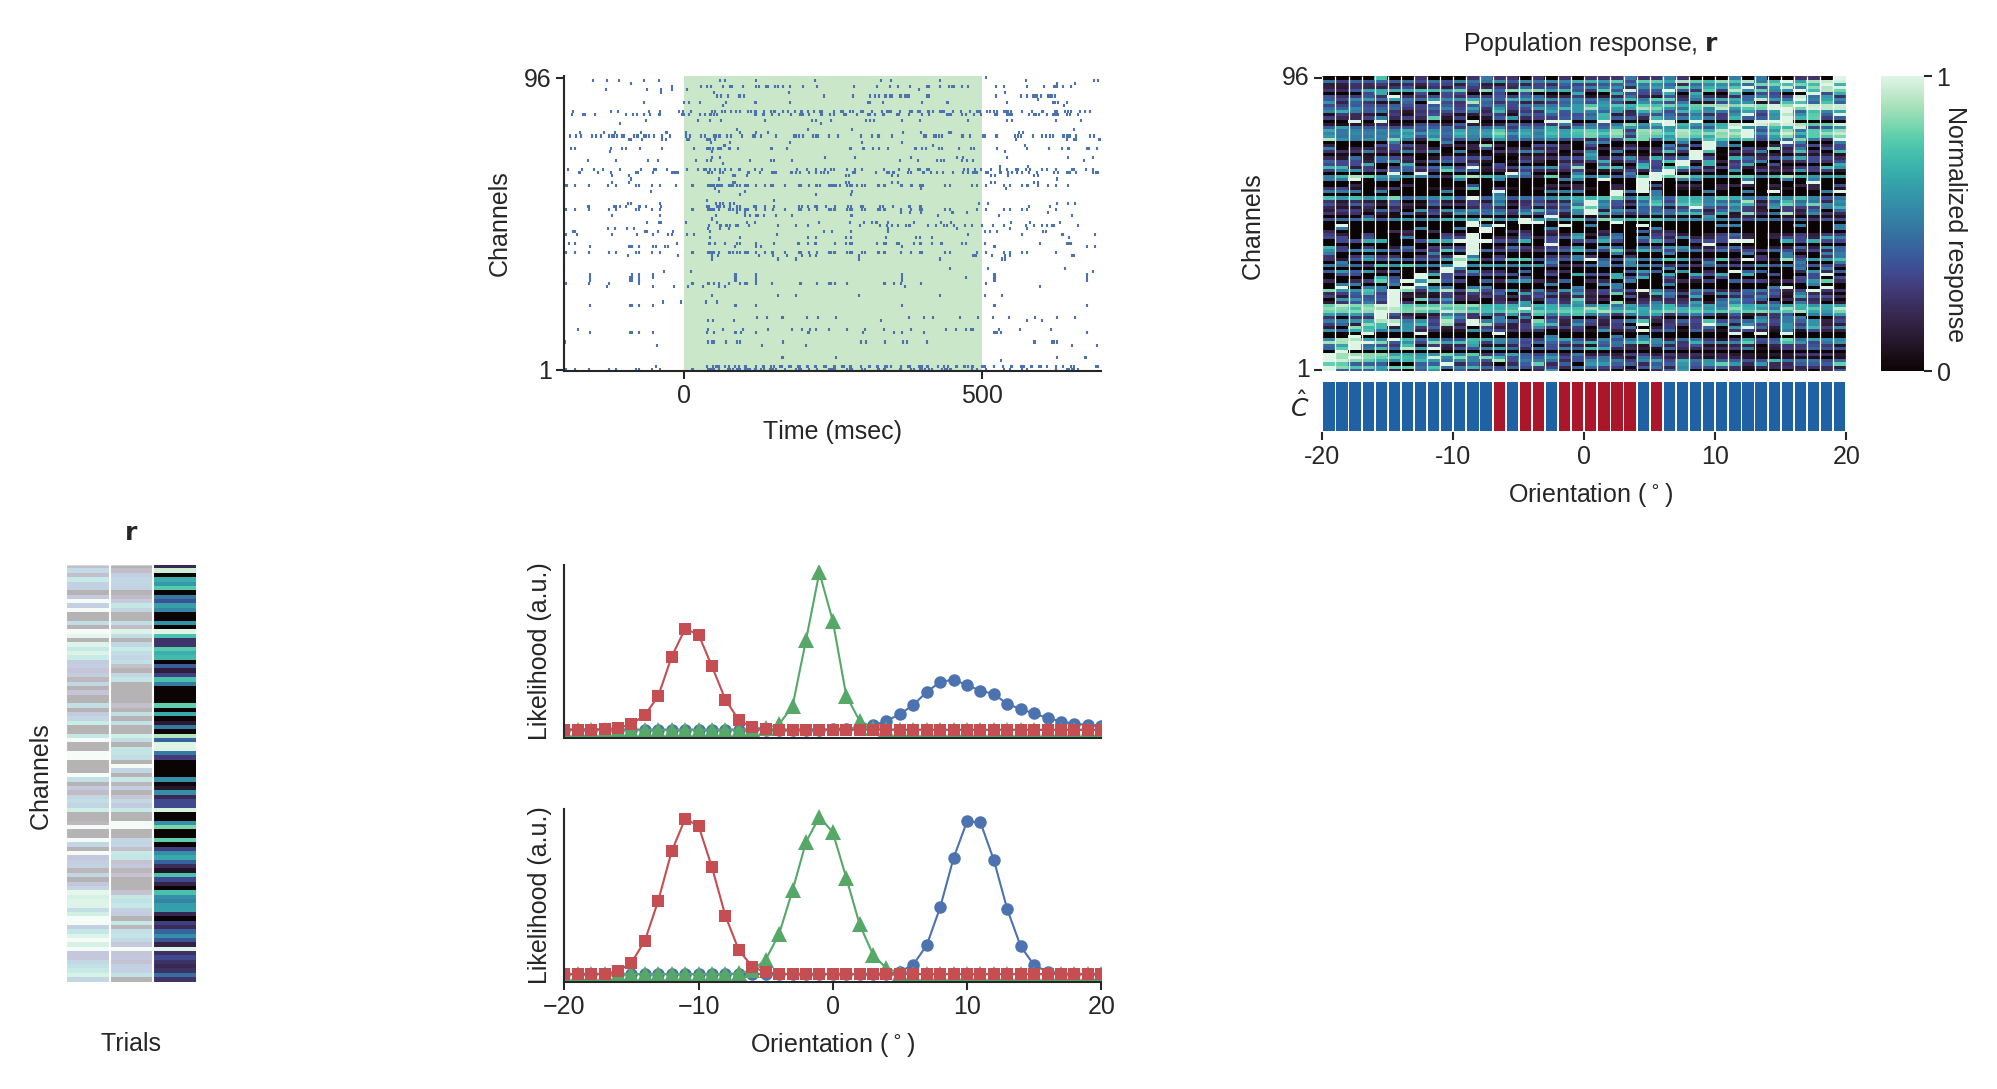

In [64]:
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

fig = plt.figure(figsize=(7.2, 4), dpi=300)


gs = gridspec.GridSpec(15, 9, hspace=hspace, wspace=wspace)
gs_right = gridspec.GridSpec(15, 1, left=0.91, right=0.93, hspace=hspace, wspace=wspace)
gs_left = gridspec.GridSpec(15, 1, left=0.07, right=0.13, hspace=hspace, wspace=wspace)

#gs_bottom = gridspec.GridSpec(1, 4, top=0.45, hspace=0.8, wspace=0.1)

gs_raster = gs[:5, 2:5]
gs_counts = gs[:5, 6:9]
gs_counts_cbar = gs_right[:5, 0]
gs_resp = gs[5, 6:9]

gs_rs = gs_left[8:, 0]

gs_likelihoods = gs[8:11, 2:5]
gs_non_bayesian = gs[12:15, 2:5]
gs_model_resp = gs[8, 6:9]
gs_class_cbar = gs_right[8, 0]




######### Counts plot ##############
ax, = add_subplots(gs_counts)
cax, = add_subplots(gs_counts_cbar)

counts = np.stack(trial_data['counts']).squeeze()
selection = trial_data['stimulus_class'] == 'A'
ori = trial_data['orientation'] - 270
pos = np.argsort(ori)
sorted_ori = ori[pos]

n_trials = 41
ori_crossing = np.arange(-20, 21)
oriticks = np.array([-20, -10, 0, 10, 20])
crossing_site = []
seed = 320 #np.random.randint(0, 1000)
print('Using seed {}'.format(seed))
np.random.seed(seed)
for v in binned_group(sorted_ori.ravel(), ori_crossing):
    crossing_site.append(np.random.choice(v[0]))
samples = pos[crossing_site]

filt = [0.25, 0.5, 0.25]
norm_counts = counts / (np.max(counts[samples], axis=0, keepdims=True) + 1e-5)
filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=norm_counts[samples])
# ordering for channels
ordering = np.argsort(np.argmax(filtered, axis=0))

sns.heatmap(norm_counts[samples][:, ordering].T, cmap=sns.cm.mako, vmin=0, vmax=1.0, ax=ax, cbar=True, cbar_ax=cax, cbar_kws={'ticks':[0, 1.0]})
#cax = fig.axes[-1] # get colorbar axes that was just added
cax.set_ylabel('Normalized response', rotation=-90, fontsize=fs)
cax.tick_params(labelsize=fs, pad=pad)
ax.vlines(np.arange(n_trials), *ax.get_ylim(), color='w', linewidth=0.3)

ax.set_xlim(0, n_trials)
ax.set_ylim([0, 96])
ax.set_yticks([0.5, 95.5])
ax.set_yticklabels(['1', '96'], rotation=0, ha='right', va='center')
ax.set_xticks([])
ax.set_ylabel('Channels ', fontsize=fs)
ax.set_title(r'Population response, $\mathbf{r}$', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)

######## Response map #######
ax, = add_subplots(gs_resp)
cp = sns.color_palette("RdBu_r", 10)
sns.heatmap(selection[None, samples], square=False, vmax=1, vmin=0, cmap=cp, cbar=False, linewidth=0.2, ax=ax)

ax.set_xlim(0, n_trials)
ax.set_xticks(oriticks+20)
ax.set_xticklabels(oriticks, rotation=0)
ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)

ax.set_yticks([])
ax.set_ylabel(r"$\hat{C}$", fontsize=fs, rotation=0, verticalalignment='center', 
              labelpad=labelpad, horizontalalignment='right')
ax.tick_params(labelsize=fs, pad=pad)

####### Raster plot ##############
sns.set_palette('deep')
ax, = add_subplots(gs_raster)
    
ax.set_xticks([])
ax.set_yticks([])

trial_num = 4
spks = (ephys.SpikesAlignedTrial() &  trial_data[trial_num]).fetch('spikes_aligned', order_by='unit_id')

#spks = spks[ordering]
for i, sp in enumerate(spks):
    ax.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i+1, linewidths=0.5)
    
ax.set_xticks([0, 500])
ax.set_xlabel('Time (msec)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Channels', fontsize=fs, labelpad=labelpad)
ax.set_xlim([-200, 700])
ax.set_ylim([0.5, 96.5])
ax.set_yticks([1, 96])
ax.axvspan(0, 500, facecolor='#2ca02c', edgecolor=None, alpha=0.25)
sns.despine(offset=offset, ax=ax, trim=trim)
ax.tick_params(labelsize=fs, pad=pad)


######## Example likelihoods to be decoded ########
ax, = add_subplots(gs_rs)
trials = [0, 4, 8]
sns.heatmap(norm_counts[trials][:, ordering].T, cmap=sns.cm.mako, vmin=0, vmax=1.0, ax=ax, cbar=False, cbar_kws={'ticks':[0, 1.0]})

# overlay gray map
ax.axvspan(0, 2, alpha=0.7, color=[1, 1, 1])
ax.vlines(np.arange(len(trials)), *ax.get_ylim(), color='w', linewidth=0.5)
ax.set_xlim(0, len(trials))
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('Trials', fontsize=fs, labelpad=4*labelpad)
ax.set_ylabel('Channels ', fontsize=fs, labelpad=labelpad)
ax.set_title(r'$\mathbf{r}$', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)


##### Readout likelihoods ######
ax, = add_subplots(gs_likelihoods)
sample_ori = np.arange(-30, 31).astype(float)
decode_ori = likelihood_data['decodeOri'].ravel() - 270
markers = ['o', '^', 's']
marker_sizes = [3, 4, 3]

for i, mk, ms in zip(trials, markers, marker_sizes):
    L = likelihood_data['oldLikelihood'][:, i]
    f = interp1d(decode_ori, L)
    Ld = f(sample_ori)
    Ld /= Ld.sum()
    ax.plot(sample_ori, Ld, '-', marker=mk, ms=ms, linewidth=0.5)
    
sns.despine(ax=ax)
ax.set_yticks([])
ax.set_xticks([])
#ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
ax.set_ylabel('Likelihood (a.u.)', fontsize=fs, labelpad=labelpad)
ax.set_xlim([-20, 20])
ax.tick_params(labelsize=fs, pad=pad)

##### Readout non-Bayesian approximated likelihoods #####
ax, = add_subplots(gs_non_bayesian)
sample_ori = np.arange(-30, 31).astype(float)
markers = ['o', '^', 's']
marker_sizes = [3, 4, 3]
sigma = l_stats['mean_sigma']
peaks = likelihood_data['originalPeaks'].squeeze() - 270

for i, mk, ms in zip(trials, markers, marker_sizes):
    L = norm.pdf(sample_ori, loc=peaks[i], scale=sigma)
    L /= L.sum()
    ax.plot(sample_ori, L, '-', marker=mk, ms=ms, linewidth=0.5)
    
sns.despine(ax=ax)
ax.set_yticks([])
ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Likelihood (a.u.)', fontsize=fs, labelpad=labelpad)
ax.set_xlim([-20, 20])
ax.tick_params(labelsize=fs, pad=pad)


# ## Model response map
# ax, = add_subplots(gs_model_resp)
# cax, = add_subplots(gs_class_cbar)
# cp = sns.color_palette("RdBu_r", 10)
# model_prespa = bayes_model_resp.presp_a
# sns.heatmap(model_prespa[None, samples], square=False, vmax=1, vmin=0, cmap=cp, cbar=True, cbar_ax=cax, 
#             cbar_kws={'ticks':[0,0.5, 1.0]}, linewidth=0.2, ax=ax)
# cax.tick_params(labelsize=fs)
# #cax.set_title(r"$P(\hat{C}=1)$", fontsize=fs)
# ax.set_yticks([])
# ax.set_xlim(0, n_trials)
# ax.set_xticks([])
# ax.set_ylabel(r"$P(\hat{C}=1)$", fontsize=fs, rotation=0, verticalalignment='center', horizontalalignment='right')
# ax.tick_params(labelsize=fs)
# ax.set_xticks(oriticks+20)
# ax.set_xticklabels(oriticks, rotation=0)
# ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
# ax.xaxis.tick_top()


fig.savefig('fig02.pdf')
fig.savefig('fig02.eps')

# Figure 3 - Likelihood functions

In [7]:
restr = 'decoder_id = 3 and lc_shuffle_id = 0'
# get every single likelihood function!
paths = (cd_dlset.DLSetInfo() & restr).fetch('dataset_path')

In [8]:
heading = (class_discrimination.CleanSpikeCountSet * class_discrimination.CSCLookup * cd_dataset.CleanContrastSessionDataSet).proj(dec_trainset_hash='dataset_hash')

In [9]:
stats_data = (heading * LikelihoodStats & restr & 'subject_id = 21').fetch()

In [10]:
all_contrasts = np.concatenate(stats_data['contrasts']).squeeze()
all_mus = np.concatenate(stats_data['mu_likelihood']).squeeze() - 270
all_oris = np.concatenate(stats_data['orientation']).squeeze() - 270
all_sigmas = np.concatenate(stats_data['sigma_likelihood'], axis=0).squeeze()

#threshold = 60 / np.sqrt(12) * 0.7
good = all_sigmas < threshold

all_contrasts = all_contrasts[good]
all_mus = all_mus[good]
all_oris = all_oris[good]

cont_edges = np.percentile(all_contrasts, np.linspace(0, 100, 10))
cont_c = 0.5 * (cont_edges[1:] + cont_edges[:-1])

AxisError: axis 1 is out of bounds for array of dimension 1

In [118]:
ori_edges = np.linspace(-40, 40, 20)

In [119]:
all_stats = []
for g in binned_group(all_contrasts, cont_edges):
    ori = all_oris[g[0]]
    mus = all_mus[g[0]]
    stats = binned_stats(ori, mus, ori_edges)
    all_stats.append(stats)

/src/v1_likelihood/v1_likelihood/utils.py:32: RuntimeWarning: Mean of empty slice
  mus = np.nanmean(assign * y, axis=1)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


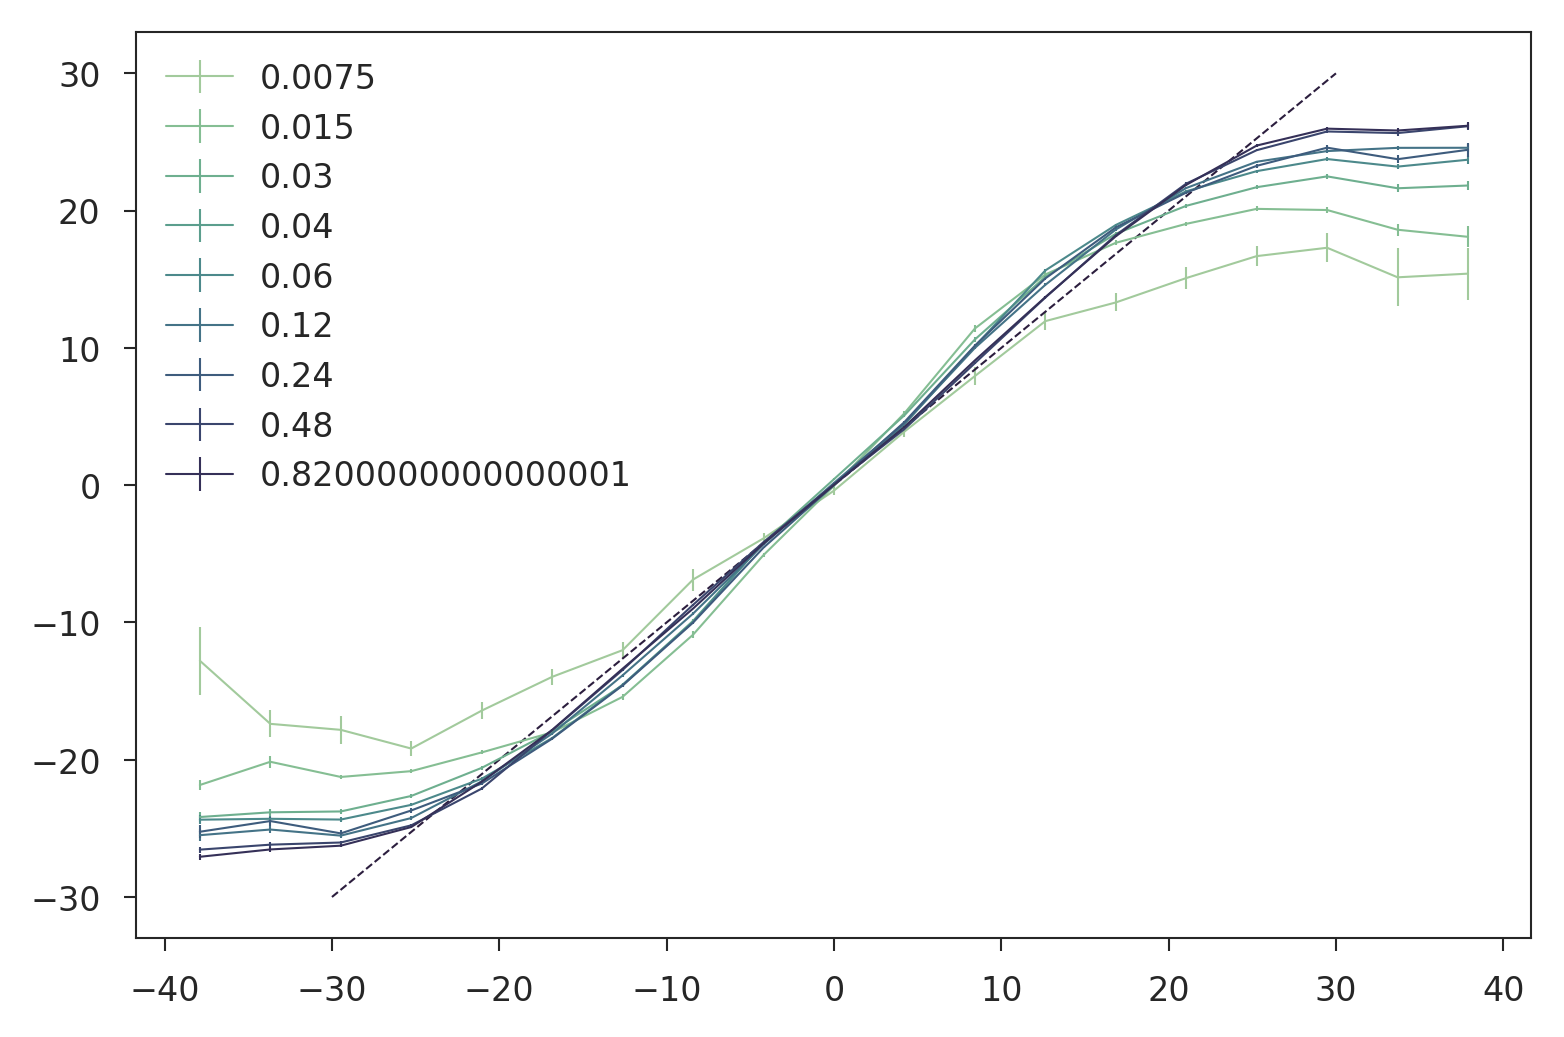

In [120]:
fig, ax = plt.subplots(1, 1, dpi=300)
for cont, stats in zip(cont_c, all_stats):
    ax.errorbar(stats.binc, stats.mu, stats.sem, label=cont)

x = np.linspace(-30, 30, 100)
ax.plot(x, x, '--')
ax.legend()

In [ ]:
LikelihoodStats.c

In [125]:
L = data['likelihood'].shape

In [126]:
pos = np.argmax(L, axis=0)

In [127]:
ori = data['orientation']

In [129]:
LikelihoodStats.drop()

`edgar_cd_analysis`.`__likelihood_stats` (1638 tuples)
Tables dropped.  Restart kernel.


In [128]:
ori[pos]

array([268.697, 272.218, 289.868, 276.56 , 258.216, 270.647, 247.159,
       273.269, 268.141, 269.529, 270.267, 302.587, 270.78 , 272.797,
       272.035, 269.992, 254.352, 271.432, 252.229, 265.521, 278.322,
       273.596, 270.908, 255.125, 260.301, 275.753, 277.407, 237.363,
       267.92 , 285.045, 272.325, 266.944, 278.118, 270.726, 266.845,
       268.144, 266.28 , 274.687, 272.881, 267.311, 269.603, 284.62 ,
       270.847, 289.55 , 268.808, 278.018, 271.498, 273.98 , 276.435,
       253.521, 274.567, 282.105, 267.92 , 274.214, 275.978, 275.84 ,
       270.06 , 254.762, 269.772, 270.36 , 265.96 , 284.529, 266.047,
       258.385, 284.744, 273.856, 250.722, 274.945, 255.773, 251.19 ,
       285.058, 270.102, 271.   , 251.033, 266.418, 270.154, 267.307,
       272.798, 268.675, 268.56 , 296.368, 265.647, 273.051, 279.761,
       256.196, 254.329, 272.662, 270.934, 268.497, 261.676, 270.227,
       243.395, 261.438, 271.765, 267.602, 281.227, 271.775, 284.307,
       271.527, 271.

In [122]:
data = loadmat(paths[0])['dataSet'][0, 0]
data2 = loadmat(paths[0])['dataSet']

In [465]:
all_contrasts = []
all_likelihoods = []
for p in tqdm(paths):
    data = loadmat(p)['dataSet'][0, 0]
    all_contrasts.append(data['contrast'].ravel())
    all_likelihoods.append(data['likelihood'])
    

100%|██████████| 546/546 [10:31<00:00,  1.16s/it]


(0, 0.022)

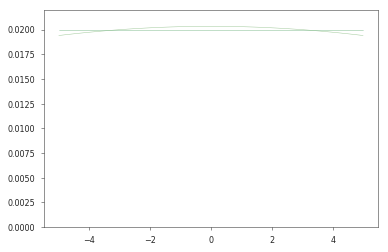

In [476]:
x = np.linspace(-5, 5)
flat = np.ones(x.shape)
flat = flat / flat.sum()
p = norm.pdf(x, loc=0, scale=16.3333)
p = p / p.sum()
plt.plot(x, p)
plt.plot(x, flat)
plt.ylim([0, 0.022])

In [466]:
all_likelihoods=np.concatenate(all_likelihoods, axis=1)
all_contrasts = np.concatenate(all_contrasts)

MemoryError: 

# Figure 4 - Model performance

In [258]:
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(X[i],y+7), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

In [200]:
tom32 = get_summary(subject=21, model=32, decoder=3, shuffle=0)
tom38 = get_summary(subject=21, model=38, decoder=3, shuffle=0)
leo32 = get_summary(subject=3, model=32, decoder=3, shuffle=0)
leo38 = get_summary(subject=3, model=38, decoder=3, shuffle=0)

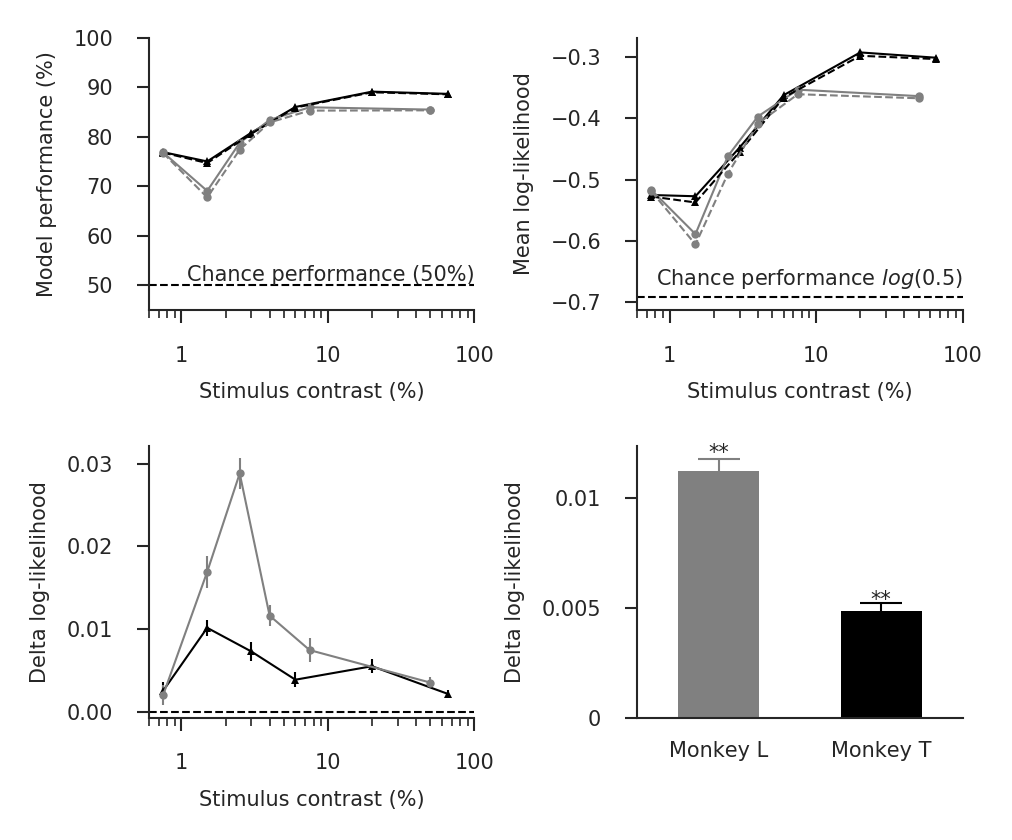

In [298]:
fs = 5.0
offset = 0
trim = False
marker_size=2


fig = plt.figure(figsize=(3.5, 3), dpi=300)
gs = gridspec.GridSpec(2, 2, wspace=0.5, hspace=0.5)

gs_correct = gs[0, 0]
gs_mean_logl = gs[0, 1]
gs_delta_logl = gs[1, 0]
gs_bar_delta = gs[1, 1]



## Performance vs contrast
ax, = add_subplots(gs_correct)
summary_sets = [tom32, leo32, tom38, leo38]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    correct_resp = np.concatenate(summary_set['correct_resp']).squeeze() * 100
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, correct_resp, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(50, linestyle='--', color='k')
ax.text(1, 50.01, 'Chance performance (50%)', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([45, 100])
ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Model performance (%)', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
#ax.minorticks_off()

## Mean log likelihood vs contrast
ax, = add_subplots(gs_mean_logl)
summary_sets = [tom32, leo32, tom38, leo38]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    test_logl = np.concatenate(summary_set['test_logl']).squeeze() 
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, test_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(np.log(0.5), linestyle='--', color='k')
ax.text(1, np.log(0.5) + 0.01, r'Chance performance $log(0.5)$', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Mean log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)


## Delta log likelihood vs contrast
ax, = add_subplots(gs_delta_logl)
summary_pairs = [(tom32, tom38), (leo32, leo38)]
markers = ['^', 'o']
linestyles=['-', '-']
colors = [tom_color, leo_color]

for (m1, m2), marker, color, ls in zip(summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    deltas.append(delta_logl)
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, delta_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(0, linestyle='--', color='k')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
#ax.set_ylim([45, 100])
#ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Delta log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
#ax.minorticks_off()

## Delta log likelihood bar plot
ax, = add_subplots(gs_bar_delta)
summary_pairs = [(leo32, leo38), (tom32, tom38),]
markers = ['o', '^']
colors = [leo_color, tom_color]
group_labels = ['Monkey L', 'Monkey T']

for i, (m1, m2), marker, color, ls in zip(count(), summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    res = ttest_rel(m1_test_logl, m2_test_logl)
    mu = delta_logl.mean()
    ax.bar(i, mu, 0.5, color=color)
    sem = delta_logl.std() / np.sqrt(len(delta_logl))
    ax.errorbar(i, mu, sem, fmt='none', capsize=5, capthick=0.5, color=color,)
    if res.pvalue < 0.01:
        ax.text(i, mu + 1.5*sem, '**', horizontalalignment='center', verticalalignment='center', fontsize=fs)
    
    
ax.set_xticks([0, 1])
ax.set_xticklabels(group_labels)
ax.set_xlim([-0.5, 1.5])
#ax.set_ylim([45, 100])
ax.set_yticks([0, 0.005, 0.01])
ax.set_yticklabels(['0', '0.005', '0.01'])
#tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Delta log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
ax.tick_params(axis='x', length=0)


fig.savefig('fig04.pdf')
#ax.minorticks_off()

# Figure 5 - Shuffling analysis

In [309]:
tom32 = get_summary(subject=21, model=32, decoder=3, shuffle=0)
tom32s = get_summary(subject=21, model=32, decoder=3, shuffle=1)
leo32 = get_summary(subject=3, model=32, decoder=3, shuffle=0)
leo32s = get_summary(subject=3, model=32, decoder=3, shuffle=1)
tom38 = get_summary(subject=21, model=38, decoder=3, shuffle=0)
tom38s = get_summary(subject=21, model=38, decoder=3, shuffle=1)
leo38 = get_summary(subject=3, model=38, decoder=3, shuffle=0)
leo38s = get_summary(subject=3, model=38, decoder=3, shuffle=1)

In [373]:
session_key = {'csc_hash': '8b19498cf522fff44c6f14c2c6a33cc5955d18a7'}
sessions = class_discrimination.CSCLookup.fetch('KEY')

session_key = sessions[82]

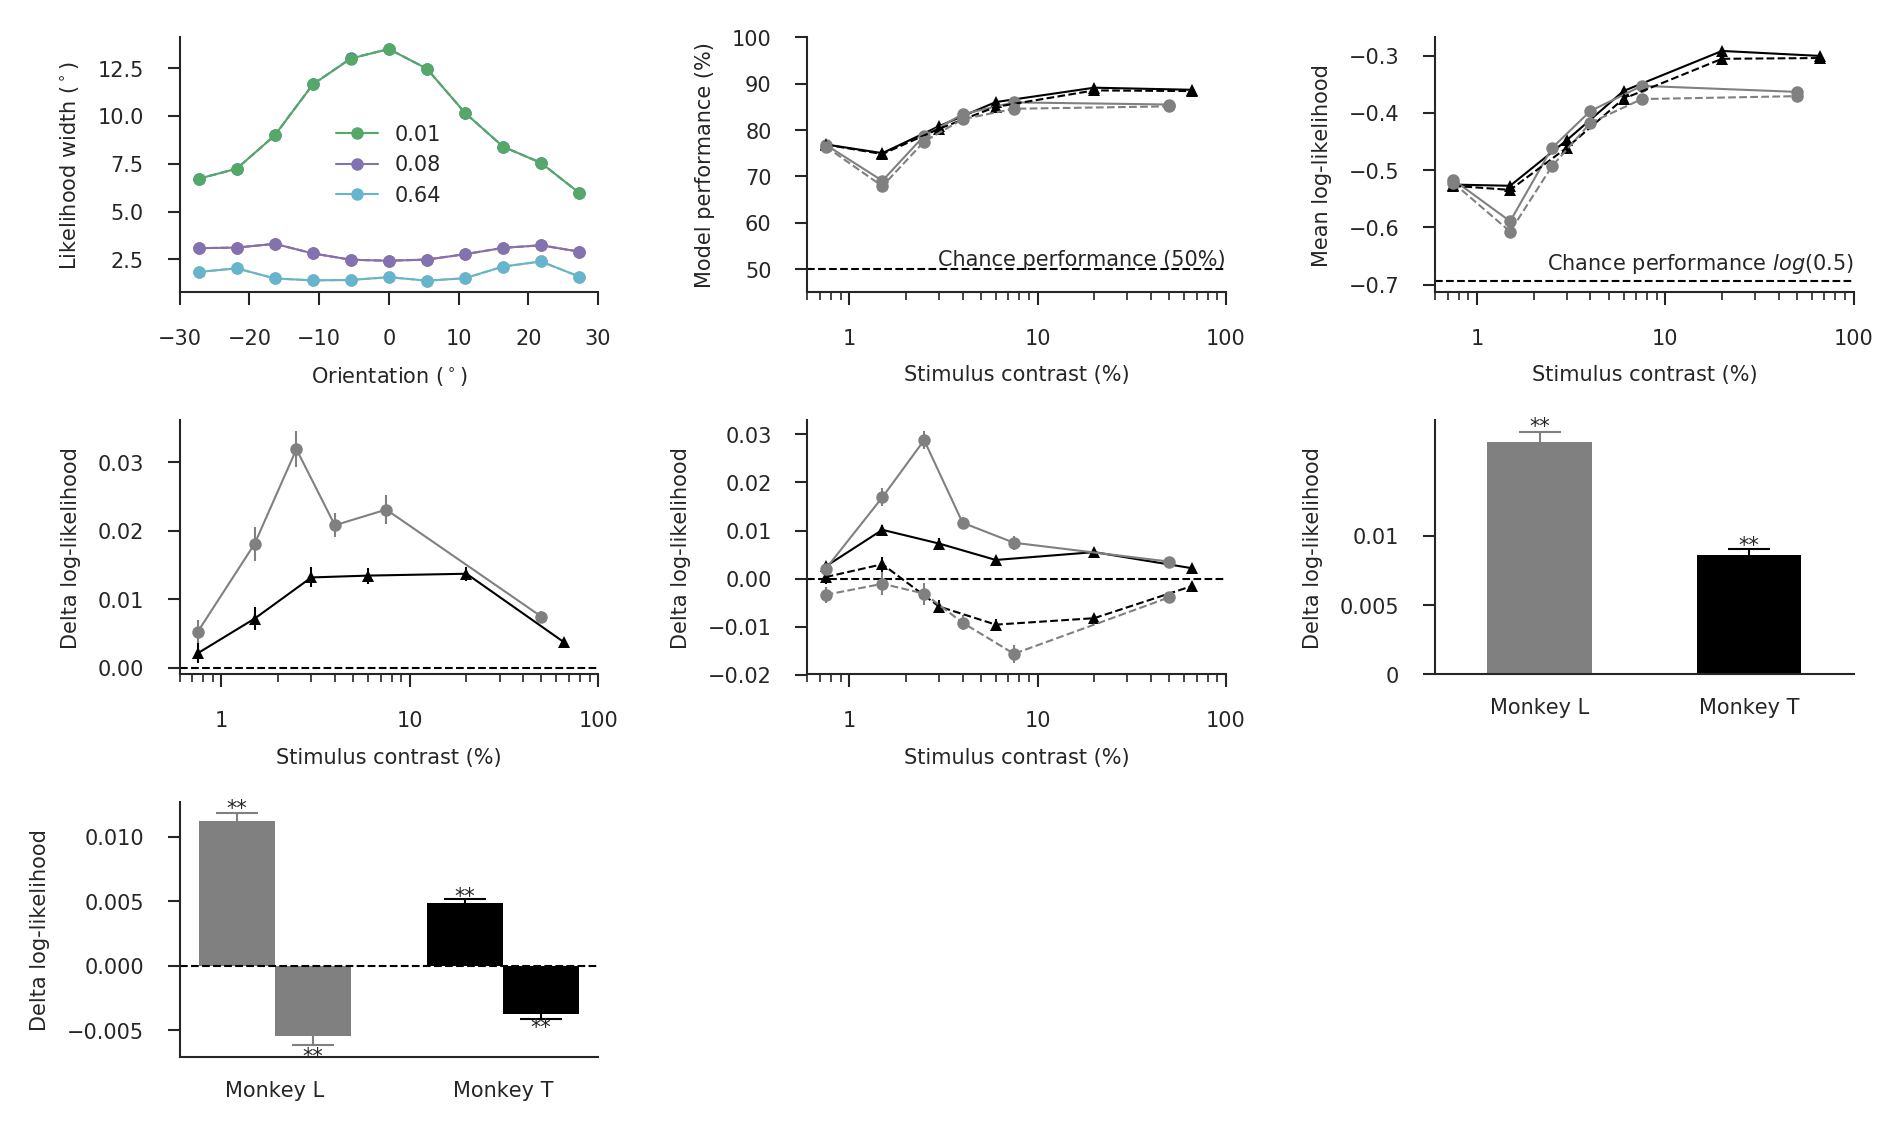

In [422]:
fs = 5.0
offset = 0
trim = False
marker_size=3

fig = plt.figure(figsize=(7.2, 4.5), dpi=300)
gs = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5)

gs_lwidth = gs[0, 0]
gs_correct = gs[0, 1]
gs_mean_logl = gs[0, 2]
gs_delta_logl = gs[1, 0]
gs_delta_logl_relative = gs[1, 1]
gs_bar_delta = gs[1, 2]
gs_bar_delta_relative = gs[2, 0]


# Likelihood width vs stimulus orientation

sns.set_palette('deep')
ax, = add_subplots(gs_lwidth)

cvsets = (cd_dlset.CVSet * (cd_dataset.CleanContrastSessionDataSet & session_key).proj(dec_trainset_hash='dataset_hash')).proj().fetch()
pos = np.argsort(cvsets['dataset_contrast'].astype(float))
cvsets = cvsets[pos]
ori_edges = np.linspace(-30, 30, 12)
for key in cvsets:
    contrast = key['dataset_contrast']
    lo_stats = (LikelihoodStats & key & 'decoder_id=3 and lc_shuffle_id=0').fetch1()
    ls_stats = (LikelihoodStats & key & 'decoder_id=3 and lc_shuffle_id=1').fetch1()
    ori_bin = (np.round((lo_stats['orientation'] - 270)/1.0) + 270).astype(int)
    unique_bins = np.unique(ori_bin)
    sieve = (unique_bins[:, None] == ori_bin)
    bin_counts = np.sum(sieve, axis=1)
    ubin = unique_bins.astype(float) - 270
    
    sp = np.sum(sieve * ls_stats['sigma_likelihood'], axis=1) / bin_counts
    stats = binned_stats(ubin, sp, ori_edges)
    ax.plot(stats.binc, stats.mu, '--', marker='o', ms=3)
    
    op = np.sum(sieve * lo_stats['sigma_likelihood'], axis=1) / bin_counts
    stats = binned_stats(ubin, op, ori_edges)
    ax.plot(stats.binc, stats.mu, marker='o', ms=3, label=contrast)
    
ax.legend(fontsize=fs)
tx=ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs)
ax.set_ylabel(r'Likelihood width ($^\circ$)', fontsize=fs)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
    

## Performance vs contrast
ax, = add_subplots(gs_correct)
summary_sets = [tom32, leo32, tom32s, leo32s]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    correct_resp = np.concatenate(summary_set['correct_resp']).squeeze() * 100
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, correct_resp, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(50, linestyle='--', color='k')
ax.text(1, 50.01, 'Chance performance (50%)', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([45, 100])
ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Model performance (%)', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
#ax.minorticks_off()

## Mean log likelihood vs contrast
ax, = add_subplots(gs_mean_logl)
summary_sets = [tom32, leo32, tom32s, leo32s]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    test_logl = np.concatenate(summary_set['test_logl']).squeeze() 
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, test_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(np.log(0.5), linestyle='--', color='k')
ax.text(1, np.log(0.5) + 0.01, r'Chance performance $log(0.5)$', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Mean log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)


## Delta log likelihood vs contrast
ax, = add_subplots(gs_delta_logl)
summary_pairs = [(tom32, tom32s),(leo32, leo32s)]
markers = ['^', 'o']
linestyles=['-', '-']
colors = [tom_color, leo_color]

for (m1, m2), marker, color, ls in zip(summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    deltas.append(delta_logl)
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, delta_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(0, linestyle='--', color='k')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
#ax.set_ylim([45, 100])
#ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Delta log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
#ax.minorticks_off()

## Delta log likelihood vs contrast relative to non-Bayesian
ax, = add_subplots(gs_delta_logl_relative)
summary_pairs = [(tom32, tom38), (tom32s, tom38s), (leo32, leo38), (leo32s, leo38s)]
markers = ['^', '^', 'o', 'o']
linestyles=['-', '--'] *2
colors = [tom_color, tom_color, leo_color, leo_color]

for (m1, m2), marker, color, ls in zip(summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    deltas.append(delta_logl)
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, delta_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(0, linestyle='--', color='k')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
#ax.set_ylim([45, 100])
#ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Delta log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
#ax.minorticks_off()

## Delta log likelihood bar plot
ax, = add_subplots(gs_bar_delta)
summary_pairs = [(leo32, leo32s), (tom32, tom32s),]
markers = ['o', '^']
colors = [leo_color, tom_color]
group_labels = ['Monkey L', 'Monkey T']

for i, (m1, m2), marker, color, ls in zip(count(), summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    res = ttest_rel(m1_test_logl, m2_test_logl)
    mu = delta_logl.mean()
    ax.bar(i, mu, 0.5, color=color)
    sem = delta_logl.std() / np.sqrt(len(delta_logl))
    ax.errorbar(i, mu, sem, fmt='none', capsize=5, capthick=0.5, color=color,)
    if res.pvalue < 0.01:
        ax.text(i, mu + 1.5*sem, '**', horizontalalignment='center', verticalalignment='center', fontsize=fs)
    
    
ax.set_xticks([0, 1])
ax.set_xticklabels(group_labels)
ax.set_xlim([-0.5, 1.5])
#ax.set_ylim([45, 100])
ax.set_yticks([0, 0.005, 0.01])
ax.set_yticklabels(['0', '0.005', '0.01'])
#tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Delta log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
ax.tick_params(axis='x', length=0)

## Delta log likelihood bar plot relative to non-Bayesian
ax, = add_subplots(gs_bar_delta_relative)
summary_pairs = [(leo32, leo38, leo32s, leo38s), (tom32, tom38, tom32s, tom38s),]
markers = ['o', '^']
colors = [leo_color, tom_color]
group_labels = ['Monkey L', 'Monkey T']

bar_spacing = 1.5
bar_width = 0.5
bar_centers = np.arange(len(summary_pairs)) * bar_spacing
for i, (m1, m1b, m2, m2b), marker, color, ls in zip(count(), summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m1b_test_logl = np.concatenate(m1b['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    m2b_test_logl = np.concatenate(m2b['test_logl']).squeeze()
    delta1_logl = m1_test_logl - m1b_test_logl
    delta2_logl = m2_test_logl - m2b_test_logl
    delta12_logl = m1_test_logl - m2_test_logl
    
    res1 = ttest_1samp(delta1_logl, 0)
    res2 = ttest_1samp(delta2_logl, 0)
    res12 = ttest_1samp(delta12_logl, 0)
    
    textshift = 0.0002
    mu1 = delta1_logl.mean()
    barc = i * bar_spacing - bar_width/2
    ax.bar(barc, mu1, bar_width, color=color)
    sem1 = delta1_logl.std() / np.sqrt(len(delta1_logl))
    ax.errorbar(barc, mu1, sem1, fmt='none', capsize=5, capthick=0.5, color=color,)
    if res1.pvalue < 0.01:
        ax.text(barc, mu1 + 2 * np.sign(mu1) * sem1 - textshift, '**', ha='center', va='center', fontsize=fs)
    
    mu2 = delta2_logl.mean()
    barc = i * bar_spacing + bar_width/2
    ax.bar(barc, mu2, bar_width, color=color)
    sem2 = delta2_logl.std() / np.sqrt(len(delta2_logl))
    ax.errorbar(barc, mu2, sem2, fmt='none', capsize=5, capthick=0.5, color=color,)
    if res2.pvalue < 0.01:
        ax.text(barc, mu2 + 2 * np.sign(mu2) * sem2 - textshift, '**', ha='center', va='center', fontsize=fs)
    
ax.axhline(0, linestyle='--', color='k')
    
ax.set_xticks(bar_centers)
ax.set_xticklabels(group_labels)
#ax.set_xlim([-0.5, 1.5])
#ax.set_ylim([45, 100])
#ax.set_yticks([0, 0.005, 0.01])
#ax.set_yticklabels(['0', '0.005', '0.01'])
#tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Delta log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
ax.tick_params(axis='x', length=0)


fig.savefig('fig05.pdf')
#ax.minorticks_off()

In [85]:
from collections import namedtuple

Aggregate = namedtuple('Aggregate', ['resp_a', 'model_correct', 'logl'])
def aggr_model_perf(key, lc_id=32, decoder_id=3, lc_shuffle_id=0):
    restr = dict(lc_id=lc_id, decoder_id=decoder_id, lc_shuffle_id=lc_shuffle_id)
    data = (cd_dlset.CVSet.Member * cd_dlset.LCModelFits & key & restr).fetch()
    aggr = {}
    ordering = np.concatenate(data['test_indices'], axis=1)
    pos = np.argsort(ordering.squeeze())
    model_choice = np.concatenate(data['model_choice'])[pos]
    model_correct = np.concatenate(data['model_correct'])[pos]
    logl = np.concatenate(data['lc_test_logl'])[pos]
    return Aggregate(model_choice, model_correct, logl)
    

In [86]:
data = aggr_model_perf(key)

In [78]:
ordering = np.concatenate(data['test_indices'], axis=1)
pos = np.argsort(ordering.squeeze())

In [80]:
np.concatenate(data['model_choice']).shape

(987, 1)

In [69]:
list(data.dtype.fields)

['lc_id',
 'test_indices',
 'cv_seed',
 'lc_testset_size',
 'cv_n',
 'lc_test_logl',
 'model_correct',
 'cv_index',
 'lc_test_mu_logl',
 'train_indices',
 'lc_shuffle_id',
 'model_choice',
 'dec_trainset_owner',
 'dec_trainset_hash',
 'prop_correct',
 'decoder_id']

In [62]:
cd_dlset.CVSet.Member() & key

dec_trainset_owner name of the table that owns this dataset,dec_trainset_hash SHA-1 hash for the primary key of the target data entry,cv_seed seed for rng,cv_n n-way cross validation,cv_index index into the N-way CV,train_indices trial indices for the training set,test_indices trial indices for the test set
cd_dataset.CleanContrastSessionDataSet,991410b681da0d8be353ef8264895eed17f45b7e,498365,10,1,=BLOB=,=BLOB=
cd_dataset.CleanContrastSessionDataSet,991410b681da0d8be353ef8264895eed17f45b7e,498365,10,2,=BLOB=,=BLOB=
cd_dataset.CleanContrastSessionDataSet,991410b681da0d8be353ef8264895eed17f45b7e,498365,10,3,=BLOB=,=BLOB=
cd_dataset.CleanContrastSessionDataSet,991410b681da0d8be353ef8264895eed17f45b7e,498365,10,4,=BLOB=,=BLOB=
cd_dataset.CleanContrastSessionDataSet,991410b681da0d8be353ef8264895eed17f45b7e,498365,10,5,=BLOB=,=BLOB=
cd_dataset.CleanContrastSessionDataSet,991410b681da0d8be353ef8264895eed17f45b7e,498365,10,6,=BLOB=,=BLOB=
cd_dataset.CleanContrastSessionDataSet,991410b681da0d8be353ef8264895eed17f45b7e,498365,10,7,=BLOB=,=BLOB=


In [58]:
cd_dlset.ShuffleParam()

lc_shuffle_id unique id for shuffle param,peak_extractor name of peak extraction function,bin_width width of bin,shuffle_seed seed for shuffling,bin_center center for defining bins
0,ClassifierModel.getMeanStd,0,123,270
1,ClassifierModel.getMeanStd,1,123,270


In [32]:
peaks

array([280.47675549, 269.12843422, 259.33332661])

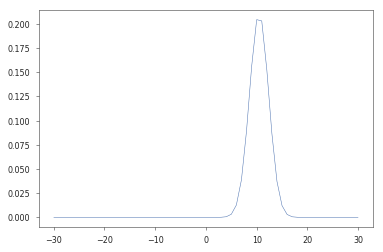

In [36]:
L = norm.pdf(sample_ori, loc=peaks[0], scale=sigma)
plt.plot(sample_ori, norm.pdf(sample_ori, loc=peaks[0], scale=sigma))

In [12]:
list(likelihood_data.dtype.fields)

['orientationBin',
 'selected_class',
 'oldLikelihood',
 'pre_stim_time',
 'correct_response',
 'stim_time',
 'originalPeaks',
 'selected_direction',
 'ephys_start_time',
 'contrast',
 'scu_id',
 'setup',
 'trial_num',
 'posterior_a',
 'session_start_time',
 'n',
 'shiftedPeaks',
 'post_stim_time',
 'count_start',
 'classdiscriminationtrial_ts',
 'sort_method_num',
 'subject_id',
 'counts',
 'goodTotalCounts',
 'delay_time',
 'likelihood',
 'csc_hash',
 'detect_method_num',
 'orientation',
 'correct_direction',
 'totalCounts',
 'goodUnits',
 'stim_start_time',
 'decodeOri',
 'stimulus_class',
 'count_stop']

In [ ]:
likelihood_data['originalPeaks']

In [402]:
decode_ori

array([200.        , 200.01750219, 200.03500438, ..., 339.96499562,
       339.98249781, 340.        ])

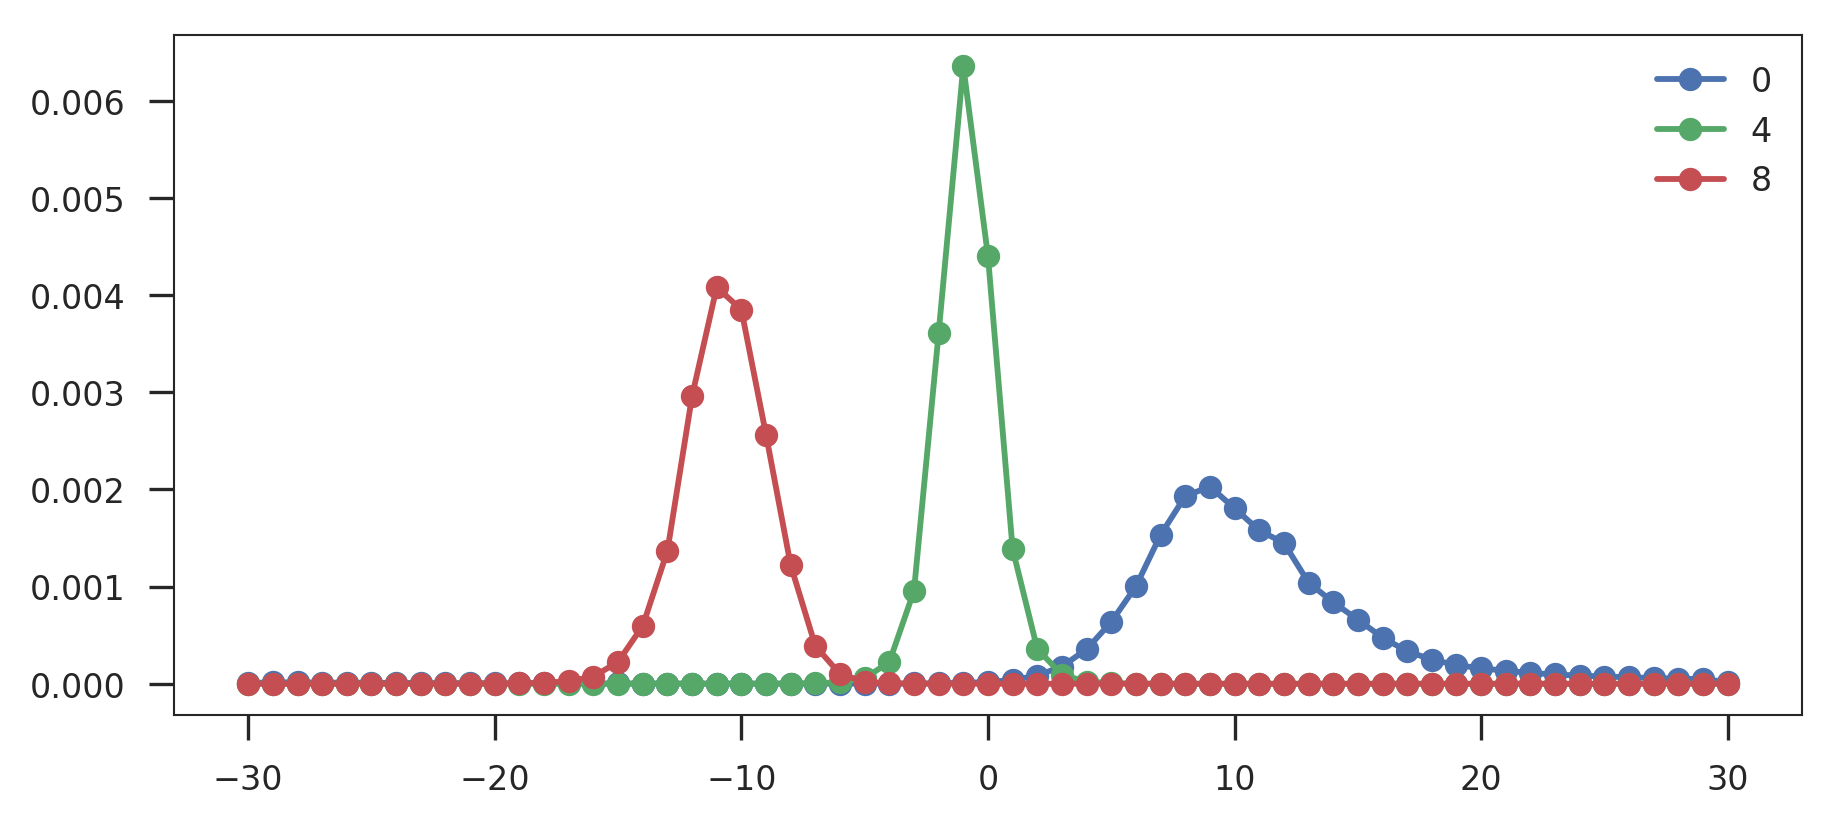

In [405]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=300)
# 0, 4, 8
sample_ori = np.arange(-30, 31).astype(float)
decode_ori = likelihood_data['decodeOri'].ravel() - 270
for i in [0, 4, 8]:
    L = likelihood_data['oldLikelihood'][:, i]
    f = interp1d(decode_ori, L)
    ax.plot(sample_ori, f(sample_ori), 'o-', label=i)
ax.legend()

In [351]:
ori_crossing

array([-20.        , -19.02439024, -18.04878049, -17.07317073,
       -16.09756098, -15.12195122, -14.14634146, -13.17073171,
       -12.19512195, -11.2195122 , -10.24390244,  -9.26829268,
        -8.29268293,  -7.31707317,  -6.34146341,  -5.36585366,
        -4.3902439 ,  -3.41463415,  -2.43902439,  -1.46341463,
        -0.48780488,   0.48780488,   1.46341463,   2.43902439,
         3.41463415,   4.3902439 ,   5.36585366,   6.34146341,
         7.31707317,   8.29268293,   9.26829268,  10.24390244,
        11.2195122 ,  12.19512195,  13.17073171,  14.14634146,
        15.12195122,  16.09756098,  17.07317073,  18.04878049,
        19.02439024,  20.        ])

# Raster plot

## All units across multiple trials arranged in Utah grid

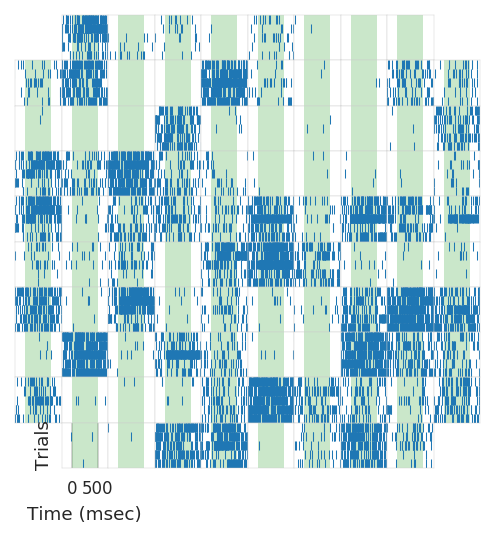

In [16]:
#key = sessions[30]
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(10, 10, figsize=(4, 4), dpi=150)
    
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
skips = [0, 9, 90, 99]
unit_axs = np.delete(axs.ravel(), skips)

for i in skips:
    axs.ravel()[i].axis('off')

axs = axs.ravel()
n_trials = 5
for unit, ax in enumerate(unit_axs):
    spks = (ephys.SpikesAlignedTrial() & class_discrimination.CleanSpikeCountTrials & dict(unit_id=unit+1) & key).fetch('spikes_aligned', order_by='trial_num')
    for i, sp in enumerate(spks[:n_trials]):
        ax.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i, linewidths=0.5)
        [ax.spines[k].set_linewidth(0.2) for k in ax.spines]
    if unit==88:
        ax.set_xticks([0, 500])
        ax.set_xlabel('Time (msec)')
        #ax.set_yticks([0, 49, 99])
        #ax.set_yticklabels([1, 50, 100])
        ax.set_ylabel('Trials')
    ax.set_xlim([-200, 700])
    ax.set_ylim([-0.5, n_trials-0.5])
    ax.axvspan(0, 500, facecolor='#2ca02c', alpha=0.25)
    

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('test.pdf')
#fig.tight_layout()

## Single trial across all channels

In [12]:
ephys.SpikesAlignedTrial & class_discrimination.CleanSpikeCountTrials & key & dict(trial_num=2)

subject_id unique identifier for subject,setup setup number,session_start_time start session timestamp,stim_start_time timestamp for stimulation start,event_type Type of stimulation event,pre_stim_time Time to bin before alignment event,post_stim_time Time after bin before alignment event,ephys_start_time start session timestamp,detect_method_num detection method index,sort_method_num clustering method index,unit_id The spike data,trial_num Trial number,spikes_aligned Set of trial spikes,spikesalignedtrial_ts automatic timestamp. Do not edit
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,1,2,=BLOB=,2015-07-28 21:05:29
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,2,2,=BLOB=,2015-07-28 21:06:56
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,3,2,=BLOB=,2015-07-28 21:08:00
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,4,2,=BLOB=,2015-07-28 21:09:03
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,5,2,=BLOB=,2015-07-28 21:10:04
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,6,2,=BLOB=,2015-07-28 21:11:09
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,7,2,=BLOB=,2015-07-28 21:12:11


In [ ]:
#key = sessions[30]
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    
ax.set_xticks([])
ax.set_yticks([])

trial_num = 4

spks = (ephys.SpikesAlignedTrial() & class_discrimination.CleanSpikeCountTrials & dict(trial_num=trial_num) & key).fetch('spikes_aligned', order_by='unit_id')

for i, sp in enumerate(spks):
    ax.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i, linewidths=0.5)
    
ax.set_xticks([0, 500])
ax.set_xlabel('Time (msec)')
#ax.set_yticks([0, 49, 99])
#ax.set_yticklabels([1, 50, 100])
ax.set_ylabel('Channels')
ax.set_xlim([-200, 700])
ax.set_ylim([-0.5, 95.5])
ax.axvspan(0, 500, facecolor='#2ca02c', edgecolor=None, alpha=0.25)
    
#fig.tight_layout()

# Counts plot

In [227]:
selection = all_data['stimulus_class'] == 'A'

ori = all_data['orientation'] - 270
pos = np.argsort(ori)
sorted_ori = ori[pos]

ori_crossing = np.linspace(-20, 20, 60)
crossing_site = np.sum(ori_crossing >= sorted_ori[:, None], axis=0)
samples = pos[crossing_site]

filt = [0.25, 0.5, 0.25]
norm_counts = counts / (np.max(counts[samples], axis=0, keepdims=True) + 1e-5)
filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=norm_counts[samples])
ordering = np.argsort(np.argmax(filtered, axis=0))

In [228]:
fig = plt.figure(figsize=(12, 8), dpi=150)
nrow = 1
parts = OrderedDict()
parts['ori_panel'] = 2
# parts['ori'] = 1
# #parts['ori_cbar'] = 1
parts['blank1'] = 1
parts['spikes'] = 16
parts['spikes_cbar'] = 1
parts['blank2'] = 1
parts['class'] = 1
n_trials = len(samples)

ncol = np.sum(list(parts.values()))

start_pos = np.cumsum([0] + list(parts.values()))[:-1]

start_pos = OrderedDict(zip(parts.keys(), start_pos))


with sns.axes_style('darkgrid'):
    
    if 'ori_panel' in parts:
        x = np.linspace(-20, 20, 100)
        sigma_a = 3
        sigma_b = 15
        p_a = np.exp(-x**2 / 2 / sigma_a**2) / np.sqrt(2 * np.pi * sigma_a**2)
        p_b = np.exp(-x**2 / 2 / sigma_b**2) / np.sqrt(2 * np.pi * sigma_b**2)
        vals = sns.color_palette("RdBu", 15)
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['ori_panel']), rowspan=1, colspan=parts['ori_panel'], fig=fig)
        ax.plot(p_a, x, color=vals[3], label=r'$C=A$')
        ax.plot(p_b, x, label=r'$C=B$')
        ax.legend()
        ax.set_ylim([-30, 30])
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.set_ylabel(r'Stimulus orientation, $s$ ($^\circ$)')
        ax.set_title(r'$p(s|C)$')
    
    
    if 'spikes' in parts and 'spikes_cbar' in parts:
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['spikes']), rowspan=1, colspan=parts['spikes'], fig=fig)

        cax = plt.subplot2grid((nrow, ncol), (0, start_pos['spikes_cbar']), rowspan=1, colspan=parts['spikes_cbar'], fig=fig)
        filt = [0.1, 0.25, 0.5, 0.25, 0.1]
        filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=norm_counts[samples])
        ordering = np.argsort(np.argmax(filtered, axis=0))
        #ordering = np.argsort(np.argmax(norm_counts[samples], axis=0))
        sns.heatmap(norm_counts[samples][:, ordering], cmap=sns.cm.mako, vmin=0, vmax=1.0, cbar_ax=cax, ax=ax, cbar_kws={'ticks':[0, 1.0]}, linewidths=0)
        cax.set_ylabel('Normalized response', rotation=-90)
        ax.hlines(np.arange(n_trials), *ax.get_xlim(), color='w', linewidth=0)

        ax.set_ylim(0, n_trials)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel('Trials ordered by stimulus orientation')
        ax.set_xlabel('Channels ordered by peak orientation')
        ax.set_title(r'Population response, $\mathbf{r}$')

        
    if 'class' in parts:
        cm = sns.color_palette("BrBG")
        cp = sns.color_palette("RdBu_r", 15)
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['class']), rowspan=1, colspan=parts['class'], fig=fig)
        sns.heatmap(selection[samples, None], square=False, vmax=1.2, vmin=-0.2, cmap=cp, cbar=False, ax=ax, linewidths=0.5)
        ax.set_yticks([])
        ax.set_ylim(0, n_trials)
        ax.set_xticks([])
        ax.set_title("Subject's decision,\n" +  r"$C$")
        #ax.hlines(np.arange(n_trials), *ax.get_xlim(), color='w', linewidth=1)

    
    # Orientation
    if 'ori' in parts:
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['ori']), rowspan=1, colspan=parts['ori'], fig=fig)
        #cax = plt.subplot2grid((nrow, ncol), (0, start_pos['ori_cbar']), rowspan=1, colspan=parts['ori_cbar'], fig=fig)

        sns.heatmap(ori[samples, None], center=0, cmap=cp, vmax=30, vmin=-30, cbar=False, cbar_ax=cax, ax=ax, linewidths=0)
        ax.yaxis.tick_right()
        ax.set_yticks([0, 0.5, 1])
        ax.set_yticklabels([-30, 0, 30], rotation=0)
        [f.set_transform(ax.transAxes) for f in ax.get_yticklabels()]
        #ax.hlines(np.arange(n_trials), *ax.get_xlim(), color='w', linewidth=1)
        ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_ylim(0, n_trials)
        ax.set_title(r'Orientation, $s$')
    
#fig.tight_layout()


NameError: name 'OrderedDict' is not defined

<Figure size 1800x1200 with 0 Axes>

Pick a session first

# Figure 3: Likelihood statistics

## Mean likelihood width vs contrast across sessions

In [426]:
subjects, all_contrasts, all_mean_sigma = (class_discrimination.CSCLookup * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * LikelihoodStats()).fetch('subject_id', 'dataset_contrast', 'mean_sigma')

all_contrasts = all_contrasts.astype(float)

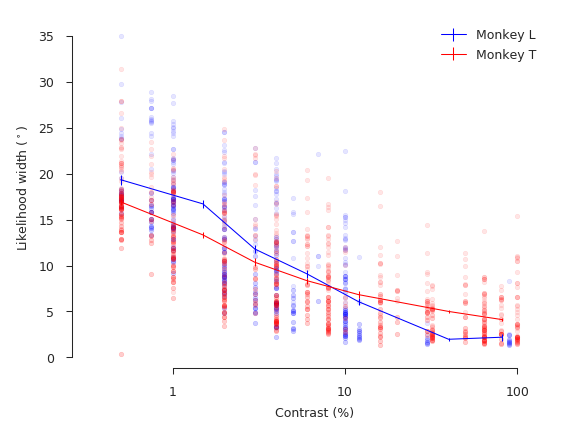

In [451]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
offset = 5
fs = 6

subj_info = [('L', 3, leo_color), ('T', 21, tom_color)]


for col, (subj_letter, subj_id, color) in enumerate(subj_info):
    pos = subjects == subj_id
    contrasts = all_contrasts[pos]
    mean_sigma = all_mean_sigma[pos]
    
    bin_edges = np.percentile(contrasts, np.linspace(0, 100, 6)) * 100
    bin_edges = np.array([0, 0.01, 0.02 , 0.04  , 0.08  , 0.16  , 0.64 ,  1.]) * 100
    cv = contrasts * 100
    stats = binned_stats(cv, mean_sigma, bin_edges)
    
    ax.scatter(cv, mean_sigma, s=5, color=color, alpha=0.1)
    ax.errorbar(stats.binc, stats.mu, stats.sem,  color=color, label='Monkey {}'.format(subj_letter))
    
ax.legend(fontsize=fs)
ax.set_xlabel('Contrast (%)', fontsize=fs)
ax.set_xscale('log')
ax.set_xlim([0.3, 150])
ax.set_ylim([0, 37])
ax.set_ylabel(r'Likelihood width ($^\circ$)', fontsize=fs)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])
ax.tick_params(labelsize=fs)
ax.minorticks_off()
sns.despine(ax=ax, offset=offset, trim=True)

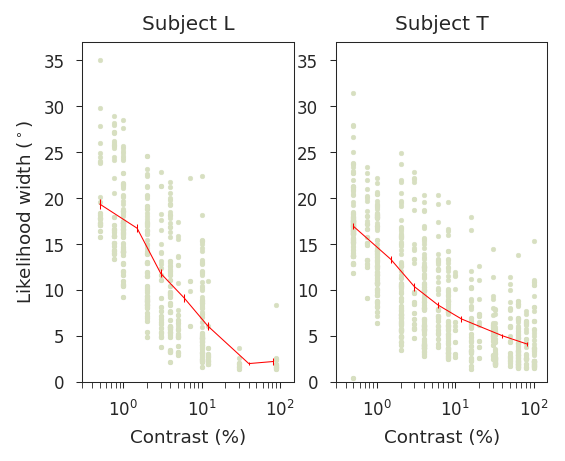

In [428]:

fig, axs = plt.subplots(1, 2, figsize=(4, 3), dpi=150)

subj_info = [('L', 3), ('T', 21)]

for col, (ax, (subj_letter, subj_id)) in enumerate(zip(axs, subj_info)):
    pos = subjects == subj_id
    contrasts = all_contrasts[pos]
    mean_sigma = all_mean_sigma[pos]
    
    bin_edges = np.percentile(contrasts, np.linspace(0, 100, 6)) * 100
    bin_edges = np.array([0, 0.01, 0.02 , 0.04  , 0.08  , 0.16  , 0.64 ,  1.]) * 100
    cv = contrasts * 100
    stats = binned_stats(cv, mean_sigma, bin_edges)
    
    ax.scatter(cv, mean_sigma, s=5)
    ax.errorbar(stats.binc, stats.mu, stats.sem,  color='r')
    ax.set_xlabel('Contrast (%)')
    ax.set_xscale('log')
    ax.set_title('Subject {}'.format(subj_letter))
    ax.set_xlim([0.3, 150])
    ax.set_ylim([0, 37])
#     ax.set_xticks(np.linspace(0.1, 1, 6))
#     ax.set_xticklabels(['{:.0f}'.format(x*100) for x in np.linspace(0, 1, 6)])
    if col==0:
        ax.set_ylabel(r'Likelihood width ($^\circ$)')


# Figure 5: Shuffling analysis

## Likelihood widths vs stimulus orientation

Original avg sigma 11.924906164071126
Shuffled avg sigma 11.924909641160713
Original avg sigma 2.6184519800679684
Shuffled avg sigma 2.6184518129334866
Original avg sigma 1.5569481990380107
Shuffled avg sigma 1.5569470015449913


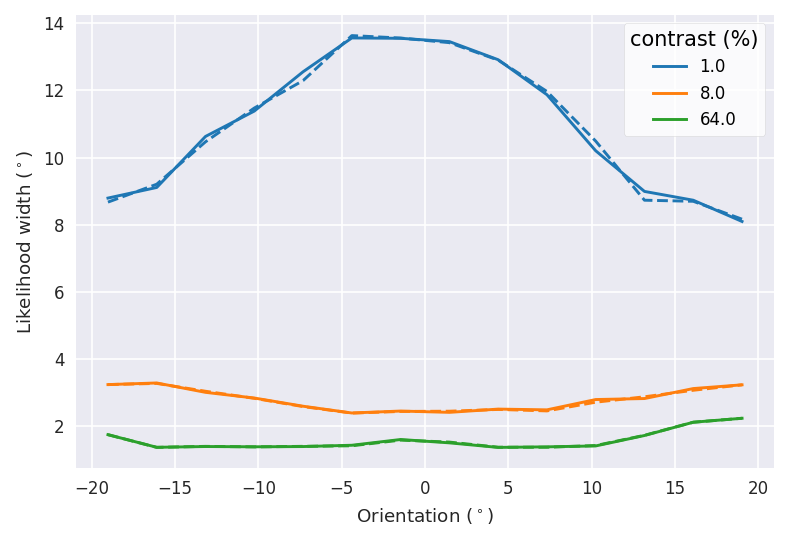

In [184]:
sessions = class_discrimination.CSCLookup.fetch('KEY')

session = sessions[82]

contrast_sessions = (cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') & session).fetch()
order = np.argsort(contrast_sessions['dataset_contrast'].astype(float))
contrast_sessions = contrast_sessions[order]

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, dpi=150)

colors = sns.color_palette()
    
for cs, color in zip(contrast_sessions, colors):
    cont = float(cs['dataset_contrast']) * 100
    
    ori, mus, sigmas = (LikelihoodStats & cs & 'decoder_id = 3 and lc_shuffle_id = 0').fetch1('orientation', 'mu_likelihood', 'sigma_likelihood')
    mus = mus - 270
    ori = ori - 270
    print('Original avg sigma', sigmas.mean())

    bin_edges = np.linspace(-20.5, 20.5, 15)
    stats = binned_stats(ori.ravel(), sigmas, bin_edges)
    ax.plot(stats.binc, stats.mu, label=cont, color=color)
                        
        
    ori, mus, sigmas = (LikelihoodStats & cs & 'decoder_id = 3 and lc_shuffle_id = 1').fetch1('orientation', 'mu_likelihood', 'sigma_likelihood')
    mus = mus - 270
    ori = ori - 270
    print('Shuffled avg sigma', sigmas.mean())
    bin_edges = np.linspace(-20.5, 20.5, 15)
    stats = binned_stats(ori.ravel(), sigmas, bin_edges)
    ax.plot(stats.binc, stats.mu, '--', color=color)
                        
                        
                        
    ax.set_xlabel(r'Orientation ($^\circ$)')
    ax.set_ylabel('Likelihood width ($^\circ$)')
ax.legend(title='contrast (%)', loc='best')

In [278]:
path = (cd_dlset.DLSetInfo & contrast_sessions[1] & 'lc_shuffle_id = 1 and decoder_id = 3').fetch1('dataset_path')
data = loadmat(path)['dataSet'][0, 0]

In [279]:
ori_bin = data['orientationBin'].ravel()
s_hat = data['decodeOri'].ravel()
Ls = data['likelihood']
Lo = data['oldLikelihood']

[272.74165868 269.15799879 272.67847131 274.36958362]
[1.81800255 2.27047956 2.09984884 2.14442085]
[273.19993892 273.95564011 269.50380448 269.95209596]
[1.81800473 2.27047654 2.09984338 2.14441533]


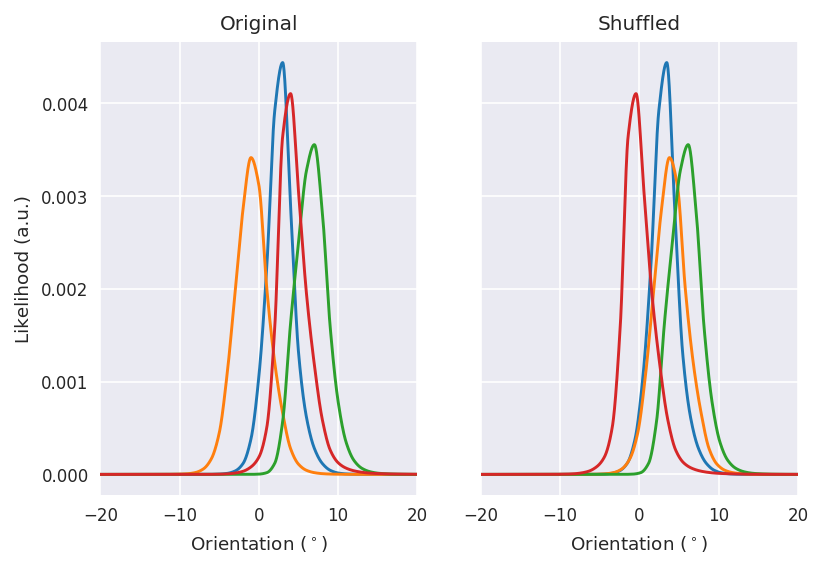

In [322]:
pos = ori_bin == 273

with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots(1, 2, dpi=150)
mu_stack = []
sigma_stack = []
titles = ['Original', 'Shuffled']
for col, (ax, L, title) in enumerate(zip(axs, [Lo, Ls], titles)):
    ax.set_xlim([-20, 20])
    mus = np.sum(s_hat[:, None] * L[:, pos], axis=0) / np.sum(L[:, pos], axis=0)
    mu_stack.append(mus)
    sigmas = np.sqrt(np.sum(s_hat[:, None]**2 * L[:, pos], axis=0) / np.sum(L[:, pos], axis=0) - mus**2)
    sort_pos = np.argsort(sigmas)
    sigma_stack.append(sorted(sigmas))
    Lp = L[:, pos]
    ax.plot(s_hat-270, Lp[:, sort_pos[[2, 24, 12, 18]]])
    print(mus[sort_pos[[2, 24, 15, 18]]])
    print(sigmas[sort_pos[[2, 24, 15, 18]]])
    ax.set_xlabel(r'Orientation ($^\circ$)')
    ax.set_title(title)
    if col==0:
        ax.set_ylabel('Likelihood (a.u.)')
    else:
        ax.set_yticklabels([])
    

mus = np.stack(mu_stack)
sigmas = np.stack(sigma_stack)

In [285]:
pos.shape

(1126,)

In [286]:
sort_pos.shape

(14,)

In [308]:
print(np.abs(mus[0] - mus[1]).max())
print(np.abs(sigmas[0]-sigmas[1]).max())

1.585605986065275e-05
3.222215940201778e-05


In [261]:
sigmas[0] - sigmas[1]

array([ 0.56035098,  0.66134751, -0.07877548,  0.95109572,  0.29894088,
        0.27500469, -0.67296618,  0.01878369,  0.84382771,  0.06336031,
       -1.67212887, -1.25690463, -0.23950172, -1.48977181,  0.26870074,
       -0.09892708,  0.4633203 , -0.55794894, -0.06336668, -0.35324172,
       -1.06380369,  0.07871838, -0.24173652,  0.49983852, -0.01834663,
       -1.47813967, -0.1680583 , -1.23870927, -1.35284172,  0.11940485,
        0.67963418, -0.89957759, -0.38014136, -0.50323696, -1.26341755,
        0.46773857,  0.53881125, -0.06426755,  0.75578139, -1.38469269,
        0.39040518,  0.07808888,  1.72721517,  0.56716089, -0.06149832,
        0.35749012,  1.23421108, -0.35918613,  0.11688874, -0.06760361,
        1.247436  ,  0.04100306, -0.06526576, -0.06428371,  0.05152367,
       -0.12045788, -0.18308051, -0.34885077,  1.01726943, -1.4264013 ,
        0.97290309,  0.25285632,  0.74876798, -0.13207681,  1.48264084,
        0.16564254,  0.23391783,  0.81423644, -0.08833483, -0.20

In [242]:
np.sum(s_hat[:, None] * L[:, pos], axis=0) / np.sum(L[:, pos], axis=0)

array([289.83123373, 292.61702778, 290.46110333, 292.67835525,
       293.38246996])

In [209]:
pos.shape

(1, 1145)

In [189]:
list(data.dtype.fields)

['trial_num',
 'stim_time',
 'likelihood',
 'decodeOri',
 'totalCounts',
 'ephys_start_time',
 'pre_stim_time',
 'stimulus_class',
 'counts',
 'selected_class',
 'session_start_time',
 'stim_start_time',
 'oldLikelihood',
 'posterior_a',
 'originalPeaks',
 'selected_direction',
 'count_stop',
 'post_stim_time',
 'orientationBin',
 'correct_direction',
 'orientation',
 'correct_response',
 'goodTotalCounts',
 'contrast',
 'classdiscriminationtrial_ts',
 'sort_method_num',
 'subject_id',
 'detect_method_num',
 'count_start',
 'n',
 'csc_hash',
 'shiftedPeaks',
 'setup',
 'scu_id',
 'goodUnits',
 'delay_time']

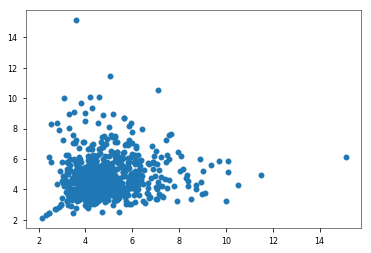

In [156]:
plt.scatter(sigmas, sigmas2)

In [89]:
mus.shape

(209,)

In [90]:
ori.shape

(1, 209)

# Select target session

In [7]:
sessions = (class_discrimination.SpikeCountSet() & 'subject_id = 21').fetch(dj.key)
key = sessions[20]

# Get the data

all_data = (class_discrimination.ClassDiscriminationTrial() * class_discrimination.SpikeCountTrials() & class_discrimination.CleanSpikeCountTrials() & key).fetch(order_by='trial_num')

# Raster plot

## All units across multiple trials arranged in Utah grid

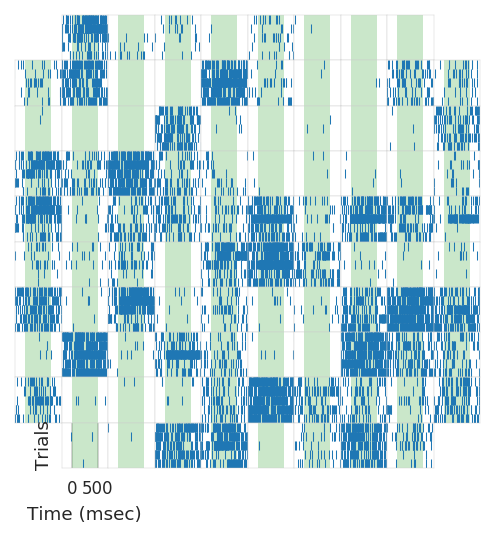

In [16]:
#key = sessions[30]
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(10, 10, figsize=(4, 4), dpi=150)
    
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
skips = [0, 9, 90, 99]
unit_axs = np.delete(axs.ravel(), skips)

for i in skips:
    axs.ravel()[i].axis('off')

axs = axs.ravel()
n_trials = 5
for unit, ax in enumerate(unit_axs):
    spks = (ephys.SpikesAlignedTrial() & class_discrimination.CleanSpikeCountTrials & dict(unit_id=unit+1) & key).fetch('spikes_aligned', order_by='trial_num')
    for i, sp in enumerate(spks[:n_trials]):
        ax.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i, linewidths=0.5)
        [ax.spines[k].set_linewidth(0.2) for k in ax.spines]
    if unit==88:
        ax.set_xticks([0, 500])
        ax.set_xlabel('Time (msec)')
        #ax.set_yticks([0, 49, 99])
        #ax.set_yticklabels([1, 50, 100])
        ax.set_ylabel('Trials')
    ax.set_xlim([-200, 700])
    ax.set_ylim([-0.5, n_trials-0.5])
    ax.axvspan(0, 500, facecolor='#2ca02c', alpha=0.25)
    

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('test.pdf')
#fig.tight_layout()

## Single trial across all channels

In [12]:
ephys.SpikesAlignedTrial & class_discrimination.CleanSpikeCountTrials & key & dict(trial_num=2)

subject_id unique identifier for subject,setup setup number,session_start_time start session timestamp,stim_start_time timestamp for stimulation start,event_type Type of stimulation event,pre_stim_time Time to bin before alignment event,post_stim_time Time after bin before alignment event,ephys_start_time start session timestamp,detect_method_num detection method index,sort_method_num clustering method index,unit_id The spike data,trial_num Trial number,spikes_aligned Set of trial spikes,spikesalignedtrial_ts automatic timestamp. Do not edit
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,1,2,=BLOB=,2015-07-28 21:05:29
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,2,2,=BLOB=,2015-07-28 21:06:56
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,3,2,=BLOB=,2015-07-28 21:08:00
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,4,2,=BLOB=,2015-07-28 21:09:03
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,5,2,=BLOB=,2015-07-28 21:10:04
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,6,2,=BLOB=,2015-07-28 21:11:09
21,2,3520958587115,3520958645036,showStimulus,300,300,3520958589588,1,4,7,2,=BLOB=,2015-07-28 21:12:11


In [ ]:
#key = sessions[30]
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    
ax.set_xticks([])
ax.set_yticks([])

trial_num = 4

spks = (ephys.SpikesAlignedTrial() & class_discrimination.CleanSpikeCountTrials & dict(trial_num=trial_num) & key).fetch('spikes_aligned', order_by='unit_id')

for i, sp in enumerate(spks):
    ax.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i, linewidths=0.5)
    
ax.set_xticks([0, 500])
ax.set_xlabel('Time (msec)')
#ax.set_yticks([0, 49, 99])
#ax.set_yticklabels([1, 50, 100])
ax.set_ylabel('Channels')
ax.set_xlim([-200, 700])
ax.set_ylim([-0.5, 95.5])
ax.axvspan(0, 500, facecolor='#2ca02c', edgecolor=None, alpha=0.25)
    
#fig.tight_layout()

# Counts plot

In [226]:
selection = all_data['stimulus_class'] == 'A'

ori = all_data['orientation'] - 270
pos = np.argsort(ori)
sorted_ori = ori[pos]

ori_crossing = np.linspace(-20, 20, 60)
crossing_site = np.sum(ori_crossing >= sorted_ori[:, None], axis=0)
samples = pos[crossing_site]

In [227]:
filt = [0.25, 0.5, 0.25]
norm_counts = counts / (np.max(counts[samples], axis=0, keepdims=True) + 1e-5)
filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=norm_counts[samples])
ordering = np.argsort(np.argmax(filtered, axis=0))

NameError: name 'norm_counts' is not defined

In [228]:
fig = plt.figure(figsize=(12, 8), dpi=150)
nrow = 1
parts = OrderedDict()
parts['ori_panel'] = 2
# parts['ori'] = 1
# #parts['ori_cbar'] = 1
parts['blank1'] = 1
parts['spikes'] = 16
parts['spikes_cbar'] = 1
parts['blank2'] = 1
parts['class'] = 1
n_trials = len(samples)

ncol = np.sum(list(parts.values()))

start_pos = np.cumsum([0] + list(parts.values()))[:-1]

start_pos = OrderedDict(zip(parts.keys(), start_pos))


with sns.axes_style('darkgrid'):
    
    if 'ori_panel' in parts:
        x = np.linspace(-20, 20, 100)
        sigma_a = 3
        sigma_b = 15
        p_a = np.exp(-x**2 / 2 / sigma_a**2) / np.sqrt(2 * np.pi * sigma_a**2)
        p_b = np.exp(-x**2 / 2 / sigma_b**2) / np.sqrt(2 * np.pi * sigma_b**2)
        vals = sns.color_palette("RdBu", 15)
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['ori_panel']), rowspan=1, colspan=parts['ori_panel'], fig=fig)
        ax.plot(p_a, x, color=vals[3], label=r'$C=A$')
        ax.plot(p_b, x, label=r'$C=B$')
        ax.legend()
        ax.set_ylim([-30, 30])
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.set_ylabel(r'Stimulus orientation, $s$ ($^\circ$)')
        ax.set_title(r'$p(s|C)$')
    
    
    if 'spikes' in parts and 'spikes_cbar' in parts:
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['spikes']), rowspan=1, colspan=parts['spikes'], fig=fig)

        cax = plt.subplot2grid((nrow, ncol), (0, start_pos['spikes_cbar']), rowspan=1, colspan=parts['spikes_cbar'], fig=fig)
        filt = [0.1, 0.25, 0.5, 0.25, 0.1]
        filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=norm_counts[samples])
        ordering = np.argsort(np.argmax(filtered, axis=0))
        #ordering = np.argsort(np.argmax(norm_counts[samples], axis=0))
        sns.heatmap(norm_counts[samples][:, ordering], cmap=sns.cm.mako, vmin=0, vmax=1.0, cbar_ax=cax, ax=ax, cbar_kws={'ticks':[0, 1.0]}, linewidths=0)
        cax.set_ylabel('Normalized response', rotation=-90)
        ax.hlines(np.arange(n_trials), *ax.get_xlim(), color='w', linewidth=0)

        ax.set_ylim(0, n_trials)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel('Trials ordered by stimulus orientation')
        ax.set_xlabel('Channels ordered by peak orientation')
        ax.set_title(r'Population response, $\mathbf{r}$')

        
    if 'class' in parts:
        cm = sns.color_palette("BrBG")
        cp = sns.color_palette("RdBu_r", 15)
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['class']), rowspan=1, colspan=parts['class'], fig=fig)
        sns.heatmap(selection[samples, None], square=False, vmax=1.2, vmin=-0.2, cmap=cp, cbar=False, ax=ax, linewidths=0.5)
        ax.set_yticks([])
        ax.set_ylim(0, n_trials)
        ax.set_xticks([])
        ax.set_title("Subject's decision,\n" +  r"$C$")
        #ax.hlines(np.arange(n_trials), *ax.get_xlim(), color='w', linewidth=1)

    
    # Orientation
    if 'ori' in parts:
        ax = plt.subplot2grid((nrow, ncol), (0, start_pos['ori']), rowspan=1, colspan=parts['ori'], fig=fig)
        #cax = plt.subplot2grid((nrow, ncol), (0, start_pos['ori_cbar']), rowspan=1, colspan=parts['ori_cbar'], fig=fig)

        sns.heatmap(ori[samples, None], center=0, cmap=cp, vmax=30, vmin=-30, cbar=False, cbar_ax=cax, ax=ax, linewidths=0)
        ax.yaxis.tick_right()
        ax.set_yticks([0, 0.5, 1])
        ax.set_yticklabels([-30, 0, 30], rotation=0)
        [f.set_transform(ax.transAxes) for f in ax.get_yticklabels()]
        #ax.hlines(np.arange(n_trials), *ax.get_xlim(), color='w', linewidth=1)
        ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_ylim(0, n_trials)
        ax.set_title(r'Orientation, $s$')
    
#fig.tight_layout()


NameError: name 'OrderedDict' is not defined

<Figure size 1800x1200 with 0 Axes>

# Trial responses

In [323]:
def get_summary(restr=None, subject=None, model=32, decoder=3, shuffle=0):
    if restr is None:
        restr = {}
    if subject is not None:
        subj = 'subject_id = {}'.format(subject)
    else:
        subj = {}
    #restr = 'subject_id = 3'
    cvset = (cd_dlset.CVSet * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup * class_discrimination.CleanSpikeCountSet & restr & subj).fetch('KEY')

    #     model = 32
    #     decoder = 3
    #     shuffle = 0

    cond = dict(lc_id=model, decoder_id=decoder, lc_shuffle_id=shuffle)
    contrasts = np.array([float(c['dataset_contrast']) for c in cvset])

    list_model_resp_A = []
    list_monkey_resp_A = []
    list_test_logl = []
    list_correct_resp = []
    
    for i, c in enumerate(cvset):
        data = (cd_dlset.LCModelFits & c & cond).fetch(order_by='cv_n')

        test_logl = np.concatenate(data['lc_test_logl'])
        list_test_logl.append(test_logl)
        model_resp = np.exp(test_logl)
        model_resp_A = np.concatenate(data['model_choice'])
        correct_resp = np.concatenate(data['model_correct'])
        list_correct_resp.append(correct_resp)
        monkey_resp_A = (model_resp_A == correct_resp)
        list_monkey_resp_A.append(monkey_resp_A)
        model_resp_A = model_resp.copy()
        model_resp_A[~monkey_resp_A] = 1 - model_resp_A[~monkey_resp_A]
        list_model_resp_A.append(model_resp_A)

    summary = {}
    summary['contrast'] = contrasts
    summary['correct_resp'] = list_correct_resp
    summary['model_resp_A'] = list_model_resp_A
    summary['monkey_resp_A'] = list_monkey_resp_A
    summary['test_logl'] = list_test_logl
    
    return summary

In [330]:
subj = 3
s32 = get_summary(model=32, decoder=3, subject=subj)
s37 = get_summary(model=37, decoder=3, subject=subj)
s38 = get_summary(model=38, decoder=3, subject=subj)
s39 = get_summary(model=39, decoder=3, subject=subj)
s40 = get_summary(model=40, decoder=3, subject=subj)
s32s = get_summary(model=32, shuffle=1, decoder=3, subject=subj)
s38s = get_summary(model=38, shuffle=1, decoder=3, subject=subj)

In [83]:
trial_contrasts = np.concatenate([[c] * len(v) for c, v in zip(s32['contrast'], s32['test_logl'])]).squeeze()

In [859]:
delta = {}
for k in s32:
    for v1, v2 in zip(s32[k], s38[k]):
        delta[k] = v1.astype(float) - v2.astype(float)

In [326]:
from scipy.stats import ttest_rel, wilcoxon

0.008120193002523656
Ttest_relResult(statistic=6.032263885023988, pvalue=7.923014517033056e-09)
WilcoxonResult(statistic=3005.5, pvalue=3.320250156273922e-11)


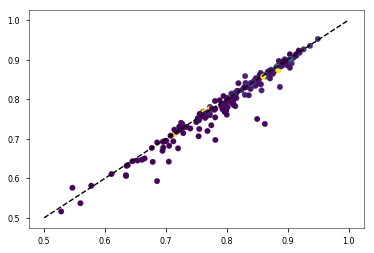

In [331]:
m1 = s32
m2 = s38
v1 = np.array([x.mean() for x in m1['correct_resp']])
v2 = np.array([x.mean() for x in m2['correct_resp']])
#v1 = np.concatenate(m1['test_logl']).squeeze()
#v2 = np.concatenate(m2['test_logl']).squeeze()
print((v1 - v2).mean())
print(ttest_rel(v1, v2))
print(wilcoxon(v1.squeeze(), v2.squeeze()))

plt.scatter(v1, v2, c=m1['contrast'])
x = np.linspace(0.5, 1)
plt.plot(x, x, '--k')

In [87]:
src = s32
contrasts = src['contrast']
selectA = [x > 0.5 for x in src['model_resp_A']]

In [90]:
targets = selectA
correct = src['correct_resp']
v = list(len(x) for x in targets)
rows = len(v)
cols = 1000 #np.max(v)

dt = np.empty((rows, cols))
dt[:] = np.nan

cont_order = np.argsort(contrasts)

cont_sorted = contrasts[cont_order]
for i, (r, c) in enumerate(zip(targets, correct)):
    r = r.squeeze()
    c = c.squeeze()
    #r = np.sort(r)[::-1]
    total = len(r)
    nA = int(round(np.sum(r >= 0.5) / total * cols))
    nAwrong = int(round(np.sum(1 - c[r >=0.5]) / total * cols))
    #nB = round(np.sum(r < 0.5) / total * cols)
    nB = cols - nA
    nBwrong = int(round(np.sum(1 - c[r <0.5]) / total * cols))

    if nA != 0:
        dt[i, :nA] = 1#r[:nA]
    if nB != 0:
        dt[i, -nB:] = 0 #r[nA:]
    if nAwrong != 0:
        dt[i, :nAwrong] = 0.5
    if nBwrong != 0:
        dt[i, -nBwrong:] = 0.5
    
dt = dt[cont_order] 

Text(0.5,187,'Trials')

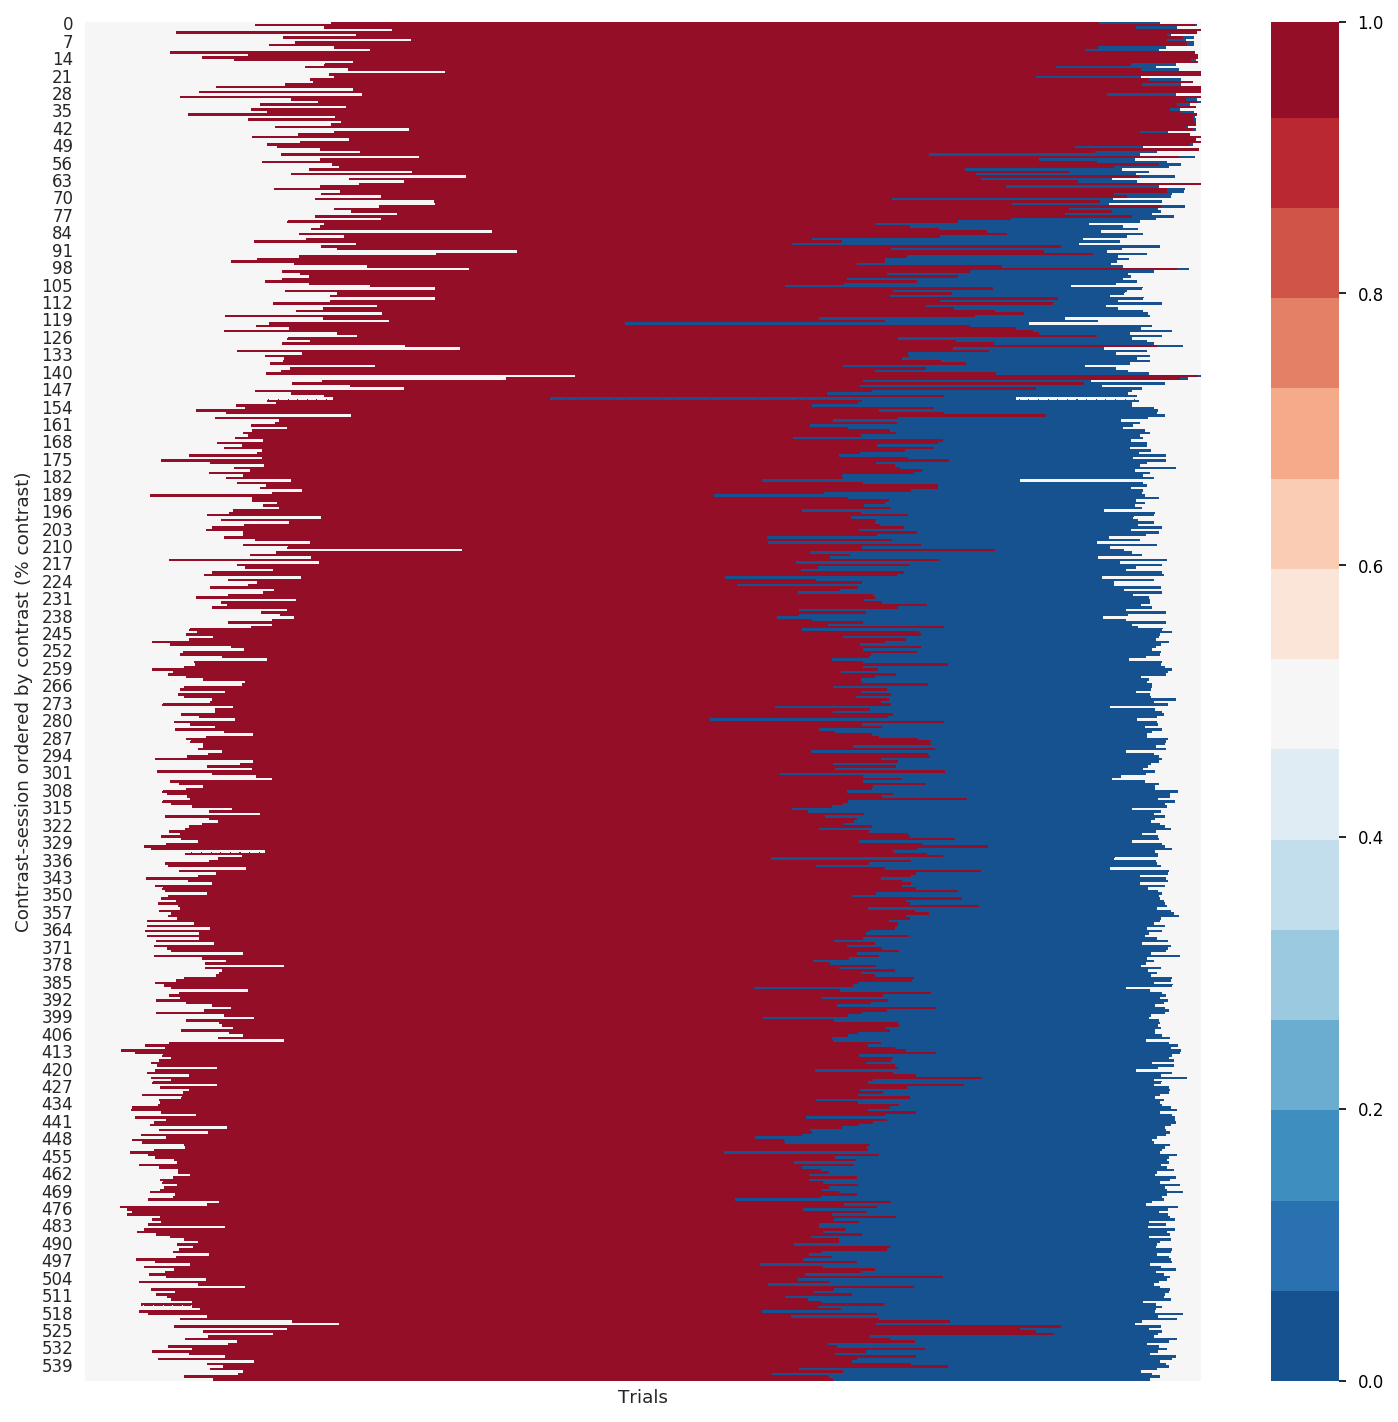

In [91]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=150)
cp = sns.color_palette("RdBu_r", 15)
sns.heatmap(dt, center=0.5, vmin=0, cmap=cp, vmax=1, ax=ax)
#ax.set_yticks(cont_pos)
#ax.set_yticklabels(cont_labels)
ax.set_ylabel('Contrast-session ordered by contrast (% contrast)')
ax.set_xticks([])
ax.set_xlabel('Trials')

Text(0.5,187,'Trials')

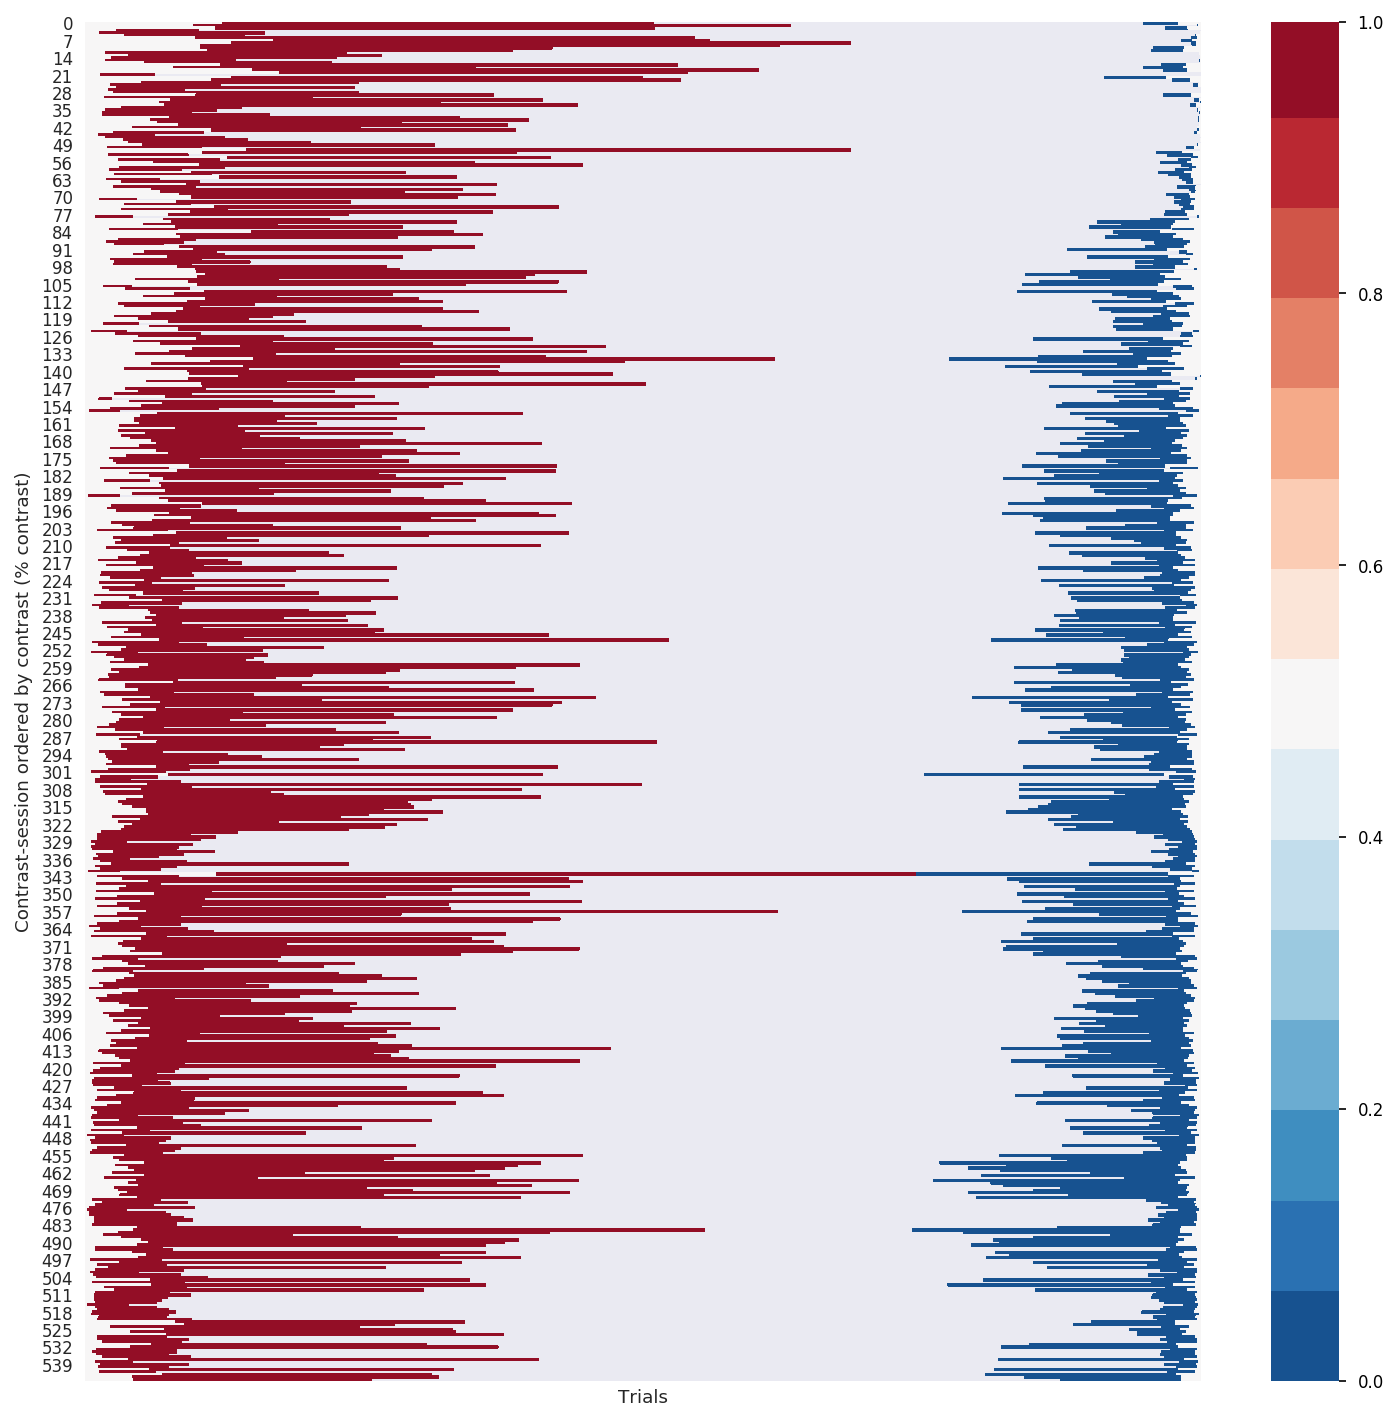

In [900]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=150)
cp = sns.color_palette("RdBu_r", 15)
sns.heatmap(dt, center=0.5, vmin=0, cmap=cp, vmax=1, ax=ax)
#ax.set_yticks(cont_pos)
#ax.set_yticklabels(cont_labels)
ax.set_ylabel('Contrast-session ordered by contrast (% contrast)')
ax.set_xticks([])
ax.set_xlabel('Trials')

In [393]:
header = cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup()

mu_sum = 0
n = 0
for c in cvset:
    data = (header * cd_dlset.LCModelFits & c & 'lc_id = 38' & 'decoder_id = 3' & 'lc_shuffle_id = 0').fetch(order_by='cv_n')
    all_trials = np.concatenate(data['lc_test_logl'])
    mu_sum += all_trials.sum()
    n += len(all_trials)
print(mu_sum / n)

-0.415847383164807


In [395]:
header = cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup()

mu_sum = 0
n = 0
for c in cvset:
    data = (header * cd_dlset.LCModelFits & c & 'lc_id = 38' & 'decoder_id = 3' & 'lc_shuffle_id = 1').fetch(order_by='cv_n')
    all_trials = np.concatenate(data['lc_test_logl'])
    mu_sum += all_trials.sum()
    n += len(all_trials)
print(mu_sum / n)

-0.4158544090313005


In [394]:
header = cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup()

mu_sum = 0
n = 0
for c in cvset:
    data = (header * cd_dlset.LCModelFits & c & 'lc_id = 32' & 'decoder_id = 3' & 'lc_shuffle_id = 0').fetch(order_by='cv_n')
    all_trials = np.concatenate(data['lc_test_logl'])
    mu_sum += all_trials.sum()
    n += len(all_trials)
print(mu_sum / n)

-0.4086651797902309


In [397]:
header = cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup()

mu_sum = 0
n = 0
for c in cvset:
    data = (header * cd_dlset.LCModelFits & c & 'lc_id = 32' & 'decoder_id = 1' & 'lc_shuffle_id = 0').fetch(order_by='cv_n')
    all_trials = np.concatenate(data['lc_test_logl'])
    mu_sum += all_trials.sum()
    n += len(all_trials)
print(mu_sum / n)

-0.45991594053950696


In [398]:
header = cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup()

mu_sum = 0
n = 0
for c in cvset:
    data = (header * cd_dlset.LCModelFits & c & 'lc_id = 38' & 'decoder_id = 1' & 'lc_shuffle_id = 0').fetch(order_by='cv_n')
    all_trials = np.concatenate(data['lc_test_logl'])
    mu_sum += all_trials.sum()
    n += len(all_trials)
print(mu_sum / n)

-0.56656269921202


In [396]:
header = cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup()

mu_sum = 0
n = 0
for c in cvset:
    data = (header * cd_dlset.LCModelFits & c & 'lc_id = 32' & 'decoder_id = 3' & 'lc_shuffle_id = 1').fetch(order_by='cv_n')
    all_trials = np.concatenate(data['lc_test_logl'])
    mu_sum += all_trials.sum()
    n += len(all_trials)
print(mu_sum / n)

-0.420211801280561


In [742]:
c

{'csc_hash': 'b60f6eaac04b071793fe70a3c130fa108439489b',
 'dataset_contrast': '0.005'}

In [ ]:
header * cd_dlset.LCModelFits 

In [570]:
header = cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup() & 'subject_id = 21'
cvset = header.fetch('KEY')
mu_sum = 0
n = 0

p_resp_As = []
monkey_resp_As = []
all_trials_list = []
contval = []

for i, c in enumerate(cvset):
    data = (header * cd_dlset.LCModelFits & c & 'lc_id = 32' & 'decoder_id = 3' & 'lc_shuffle_id = 0').fetch(order_by='cv_n')
    contval.append(float(data['dataset_contrast'][0]))
    all_trials = np.concatenate(data['lc_test_logl'])
    all_trials_list.append(all_trials)
    p_resp = np.exp(all_trials)
    model_resp_A = np.concatenate(data['model_choice'])
    correct_resp = np.concatenate(data['model_correct'])
    monkey_resp_A = (model_resp_A == correct_resp)
    monkey_resp_As.append(monkey_resp_A)
    p_resp_A = p_resp.copy()
    p_resp_A[~monkey_resp_A] = 1 - p_resp_A[~monkey_resp_A]
    p_resp_As.append(p_resp_A)

In [583]:
targets = p_resp_As
v = list(len(x) for x in targets)
contval = np.array(contval)
rows = len(v)
cols = np.max(v)

dt = np.empty((rows, cols))
dt[:] = np.nan

corder = np.argsort(contval)

csorted = contval[corder]
for i, r in enumerate(targets):
    r = r.squeeze()
    r = np.sort(r)[::-1]
    nA = np.sum(r >= 0.5)
    nB = np.sum(r < 0.5)
    if nA != 0:
        dt[i, :nA] = r[:nA]
    if nB != 0:
        dt[i, -nB:] = r[nA:]
    
dt = dt[corder] 

In [584]:
cont_labels = np.linspace(0, 1, 11)
cont_pos = np.sum(csorted[:, None] <= cont_labels,axis=0)
cont_labels = ['{:.0f}'.format(x*100) for x in cont_labels]

Text(0.5,89.4,'Trials')

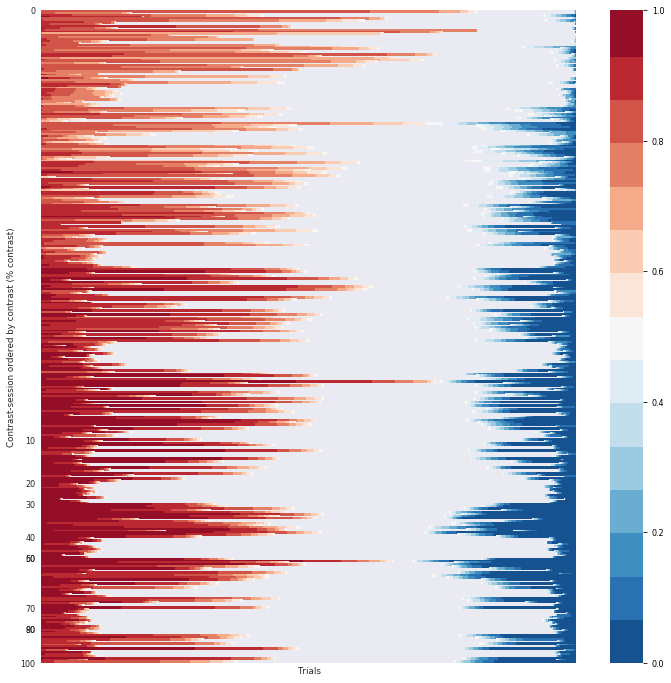

In [586]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=150)
cp = sns.color_palette("RdBu_r", 15)
sns.heatmap(dt, center=0.5, vmin=0, cmap=cp, vmax=1, ax=ax)
ax.set_yticks(cont_pos)
ax.set_yticklabels(cont_labels)
ax.set_ylabel('Contrast-session ordered by contrast (% contrast)')
ax.set_xticks([])
ax.set_xlabel('Trials')

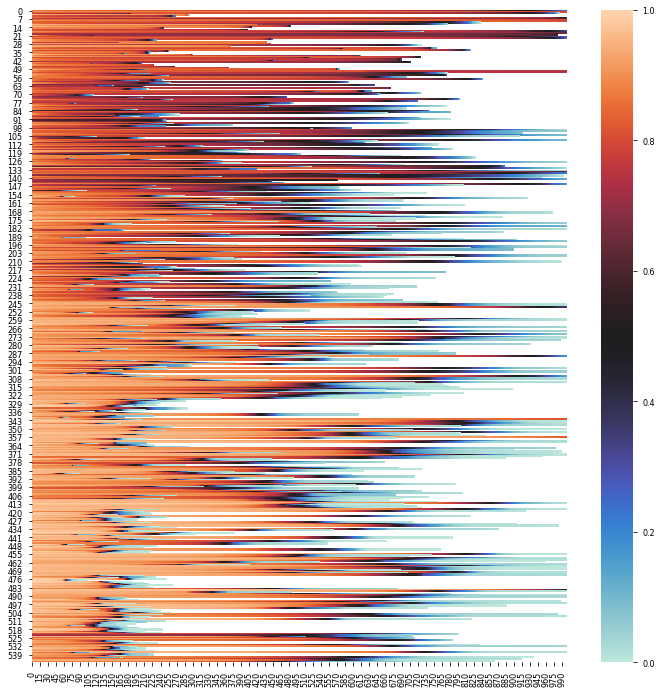

In [477]:
fig = plt.figure(figsize=(12, 12))
sns.heatmap(dt, center=0.5, vmin=0, vmax=1)

In [448]:
vmax

1818

In [439]:
np.concatenate(p_resp_As)

array([[0.13119123],
       [0.02355316],
       [0.02355316],
       ...,
       [0.8894512 ],
       [0.74939055],
       [0.90707387]])

In [443]:
np.concatenate(correct_resps)

0.8256265536089884

In [417]:
data = (cd_dlset.LCModelFits & c & 'lc_id = 32' & 'decoder_id = 3' & 'lc_shuffle_id = 0').fetch(order_by='cv_n')

In [419]:
all_trials = np.concatenate(data['lc_test_logl'])

In [427]:
v = model_resp_A == correct_resp

In [428]:
p_resp_A = p_resp.copy()

In [431]:
p_resp_A.shape

(593, 1)

In [432]:
v.shape

(209, 1)

In [429]:
p_resp_A[~v] 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 593 but corresponding boolean dimension is 209

In [420]:
model_resp_A = np.concatenate(data['model_choice'])

In [421]:
correct_resp = np.concatenate(data['model_correct'])

In [425]:
len(all_trials)

209

In [424]:
len(model_resp_A)

209

In [422]:
len(correct_resp)

209

In [388]:
from scipy.stats import ttest_rel

In [ ]:
from scipy.stats.ttest_rel

In [408]:
p_resp = np.exp(all_trials)

In [409]:
model_resp_A = np.concatenate(data['model_choice'])

In [410]:
correct_resp = np.concatenate(data['model_correct'])

In [412]:
monkey_resp_A = (model_resp_A == correct_resp)

In [317]:
p_resp_A = p_resp.copy()
p_resp_A[~monkey_resp_A] = 1 - p_resp_A[~monkey_resp_A]

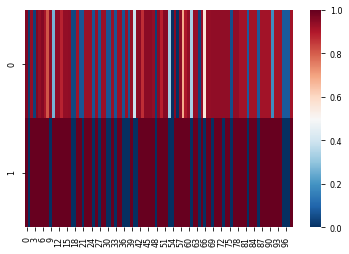

In [318]:
sns.heatmap(np.vstack((p_resp_A.T, monkey_resp_A.T)), center=0.5, vmin=0, vmax=1, cmap='RdBu_r')

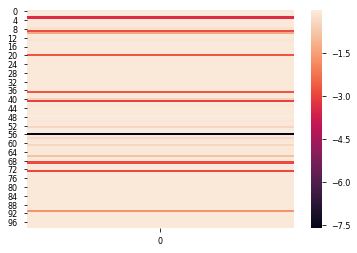

In [321]:
sns.heatmap(all_trials)

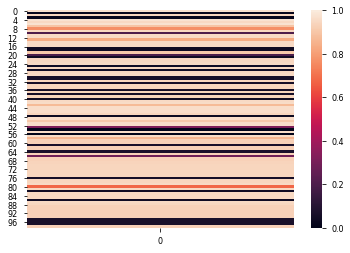

In [309]:
sns.heatmap(p_resp_A, vmin=0, vmax=1)

In [ ]:
true_resp_A = 

In [215]:
df.columns

Index(['lc_id', 'dec_trainset_owner', 'dec_trainset_hash', 'decoder_id',
       'lc_shuffle_id', 'cv_seed', 'cv_n', 'cv_index', 'lc_test_mu_logl',
       'lc_test_logl', 'lc_testset_size', 'model_choice', 'model_correct',
       'prop_correct'],
      dtype='object')

In [216]:
df

,lc_id,dec_trainset_owner,dec_trainset_hash,decoder_id,lc_shuffle_id,cv_seed,cv_n,cv_index,lc_test_mu_logl,lc_test_logl,lc_testset_size,model_choice,model_correct,prop_correct
0,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,1,-0.332712,"[[-2.031099230628428], [-0.023834974179050523]...",21,"[[False], [False], [False], [False], [False], ...","[[False], [True], [True], [True], [True], [Tru...",0.904762
1,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,2,-0.032770,"[[-0.025084816025074883], [-0.0217741431889017...",21,"[[True], [True], [True], [True], [True], [True...","[[True], [True], [True], [True], [True], [True...",1.000000
2,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,3,-0.454132,"[[-0.04428816692380463], [-0.04434527648298573...",21,"[[False], [True], [True], [True], [True], [Tru...","[[True], [True], [True], [True], [True], [True...",0.857143
3,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,4,-0.139385,"[[-0.022940752901543564], [-0.0414345937170251...",21,"[[False], [True], [True], [True], [False], [Tr...","[[True], [True], [True], [True], [True], [True...",0.952381
4,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,5,-0.358543,"[[-0.0102739942356947], [-0.010541977828354678...",21,"[[True], [True], [True], [False], [True], [Tru...","[[True], [True], [True], [True], [True], [True...",0.952381
5,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,6,-0.341233,"[[-0.03073166393226847], [-0.02674018894626792...",20,"[[True], [True], [True], [True], [True], [True...","[[True], [True], [True], [True], [True], [True...",0.850000
6,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,7,-0.081952,"[[-0.7376389404319348], [-0.04393352843258406]...",21,"[[True], [True], [True], [True], [False], [Fal...","[[False], [True], [True], [True], [True], [Tru...",0.952381
7,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,8,-0.154880,"[[-0.018321138210034026], [-0.0368123667481392...",21,"[[False], [True], [True], [True], [True], [Fal...","[[True], [True], [True], [True], [True], [True...",0.904762
8,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,9,-0.433402,"[[-0.008417047393203767], [-0.0110296544713583...",21,"[[False], [True], [True], [True], [True], [Tru...","[[True], [True], [True], [True], [True], [True...",0.904762
9,32,cd_dataset.CleanContrastSessionDataSet,000d15743a35939fcb0fd47117b3d461bf9786fa,3,0,498365,10,10,-0.318808,"[[-0.024014052745035836], [-0.0515473356050954...",21,"[[True], [True], [True], [False], [False], [Fa...","[[True], [True], [True], [True], [True], [True...",0.857143


In [112]:
starts

array([10, 11, 12, 13, 14])

In [ ]:
fig.savefig

In [ ]:
fig.save()

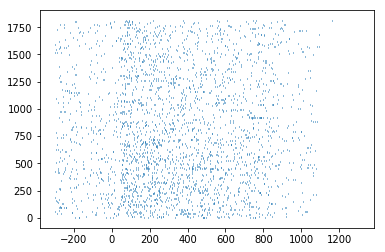

In [36]:
sessions = (class_discrimination.SpikeCountSet() & 'subject_id = 21').fetch(dj.key)

key = sessions[0]
spks = (ephys.SpikesAlignedTrial() & class_discrimination.CleanSpikeCountTrials & dict(unit_id=1) & key).fetch('spikes_aligned', order_by='trial_num')
for i, sp in enumerate(spks):
    plt.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i, linewidths=1.0)

In [38]:
key

{'count_start': 0,
 'count_stop': 500,
 'detect_method_num': 1,
 'ephys_start_time': 3450715285435,
 'event_type': 'showStimulus',
 'post_stim_time': 300,
 'pre_stim_time': 300,
 'session_start_time': 3450715278622,
 'setup': 2,
 'sort_method_num': 4,
 'stim_start_time': 3450716178152,
 'subject_id': 3}

In [ ]:
class_discrimination.

In [30]:
df = pd.DataFrame(all_data)

In [31]:
counts = np.stack(df['counts']).squeeze()